# Pattern analysis
----

Analys of unexpected pattern found with $\texttt{UnexPattern}$ algorithm

**Libraries**

In [93]:
from collections import Counter, defaultdict
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import sparse
from scipy.stats import wasserstein_distance
from tqdm import tqdm


import gensim
from gensim.test.utils import common_texts
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix
from gensim.similarities import WordEmbeddingSimilarityIndex

from sknetwork.clustering import Louvain, KMeans
from sknetwork.data import load_netset
from sknetwork.embedding import Spectral
from sknetwork.gnn import GNNClassifier
from sknetwork.ranking import top_k
from sknetwork.topology import get_connected_components
from sknetwork.utils import get_degrees, KMeansDense
from sknetwork.visualization import svg_graph

## RQ1: How efficient is algorithm according to pruning techniques?
---

### Extent sizes  

We compare sizes of pattern (respectively the length of their extent and intent) considering if the list of attributes in $\texttt{UnexPattern}$ algorithm has been sorted or not.

In [2]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')

In [72]:
def load_result(path, filename):
    with open(f'{path}/{filename}.bin', 'rb') as data:
        result = pickle.load(data)
    return result

In [3]:
def get_summarized_graph(adjacency, concepts):
    """Get summarized graph given concepts and original adjacency matrix."""
    
    rows, cols = [], []

    for c in concepts:

        # exclude first element of lattice 
        if len(c[1]) > 0:
            nodes = sorted(c[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_concept = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_concept.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_concept.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

In [4]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['means'], color=color)

**Load data**

We use unexpected patterns generated with minimum support values for nodes and attributes $s=5$ and $\beta=5$.

In [5]:
dataset = 'wikivitals'
s = 5
beta = 5

sorted_attributes = True

# Load result
with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
    result_ordered = pickle.load(data)
    
sorted_attributes = False

# Load result
with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
    result_not_ordered = pickle.load(data)

**Pattern size distributions**

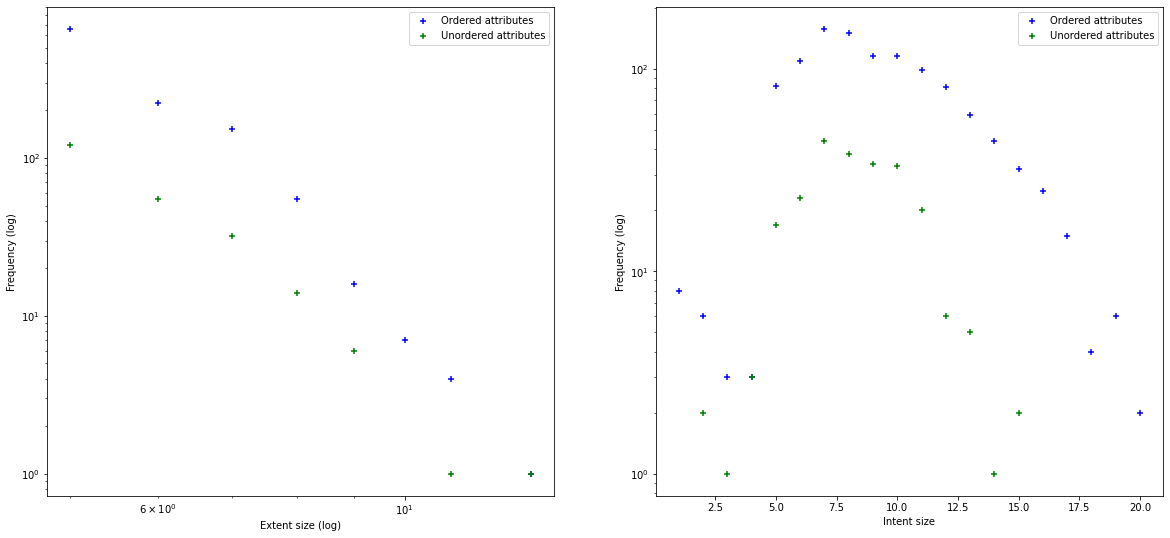

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
plot_distrib([len(p[0]) for p in result_ordered if len(p[1]) > 0], ax=ax[0], xlabel='Extent size', color='blue', label='Ordered attributes')
plot_distrib([len(p[0]) for p in result_not_ordered if len(p[1]) > 0], ax=ax[0], xlabel='Extent size', color='green', label='Unordered attributes')
plot_distrib([len(p[1]) for p in result_ordered if len(p[1]) > 0], ax=ax[1], xlabel='Intent size', log=False, color='blue', label='Ordered attributes')
plot_distrib([len(p[1]) for p in result_not_ordered if len(p[1]) > 0], ax=ax[1], xlabel='Intent size', log=False, color='green', label='Unordered attributes')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


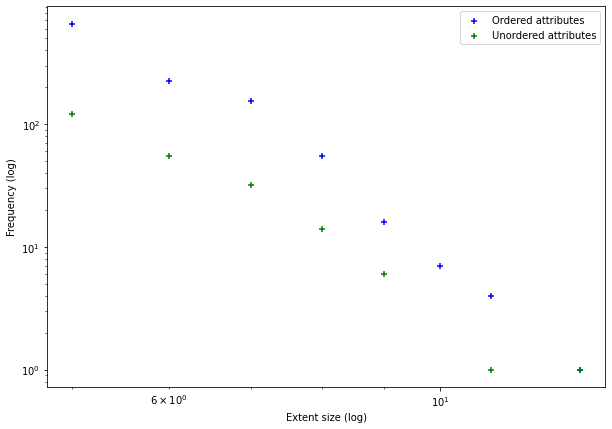

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_distrib([len(p[0]) for p in result_ordered if len(p[1]) > 0], ax=ax, xlabel='Extent size', color='blue', label='Ordered attributes')
plot_distrib([len(p[0]) for p in result_not_ordered if len(p[1]) > 0], ax=ax, xlabel='Extent size', color='green', label='Unordered attributes')
plt.savefig(f'../output/img/extent_size_distrib.eps', dpi=300)

**All datasets**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


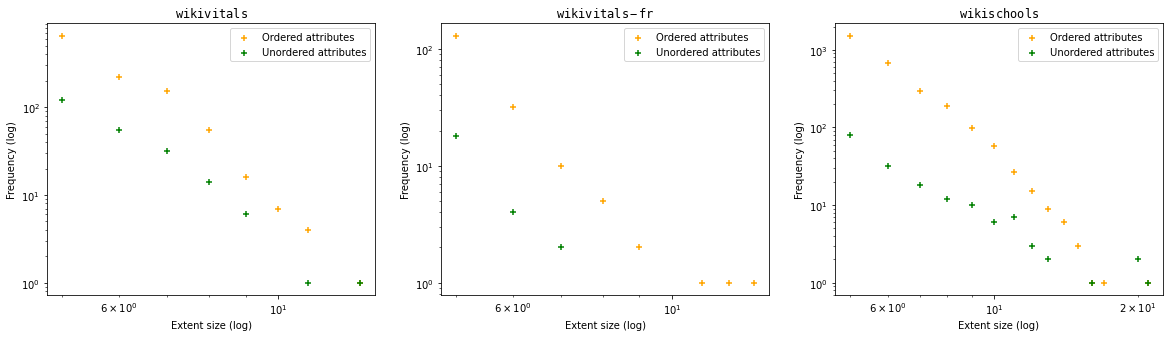

In [8]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
s = 5
beta = 5

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, dataset in enumerate(datasets):

    sorted_attributes = True

    # Load result
    with open(f"../output/result/result_{dataset}_{beta}_{s}_order{sorted_attributes}.bin", "rb") as data:
        result_ordered = pickle.load(data)

    sorted_attributes = False

    # Load result
    with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
        result_not_ordered = pickle.load(data)
        
    # plot results
    plot_distrib([len(p[0]) for p in result_ordered if len(p[1]) > 0], ax=ax[i], xlabel='Extent size', color='orange', label='Ordered attributes')
    plot_distrib([len(p[0]) for p in result_not_ordered if len(p[1]) > 0], ax=ax[i], xlabel='Extent size', color='green', label='Unordered attributes')

ax[0].set_title(r'$\tt{wikivitals}$')
ax[1].set_title(r'$\tt{wikivitals-fr}$')
ax[2].set_title(r'$\tt{wikischools}$')
    
plt.savefig(f'../output/img/extent_size_distrib_all_datasets.eps', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


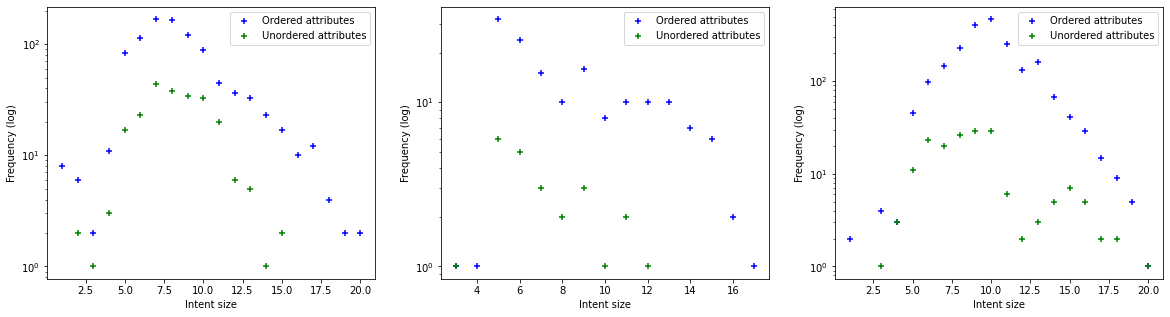

In [9]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
s = 5
beta = 5

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, dataset in enumerate(datasets):

    sorted_attributes = True

    # Load result
    with open(f"../output/result/result_{dataset}_{beta}_{s}.bin", "rb") as data:
        result_ordered = pickle.load(data)

    sorted_attributes = False

    # Load result
    with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
        result_not_ordered = pickle.load(data)
        
    # plot results
    plot_distrib([len(p[1]) for p in result_ordered if len(p[1]) > 0], ax=ax[i], log=False, xlabel='Intent size', color='blue', label='Ordered attributes')
    plot_distrib([len(p[1]) for p in result_not_ordered if len(p[1]) > 0], ax=ax[i], log=False, xlabel='Intent size', color='green', label='Unordered attributes')
    
plt.savefig(f'../output/img/intent_size_distrib_all_datasets.eps', dpi=300)

### Ordering attributes impact  

We measure the impact of ordering list of parameters in algorithm in terms of computation time.

In [358]:
# max_support = 100
logs = {'wikivitals': {
    'ordered attributes': {'beta_8': [12.87, 26.76, 63.87, 76.57],
               'beta_7': [28.24, 43.26, 84.10, 169.37],
               'beta_6': [15.93, 29.57, 128.29, 242.44],
               'beta_5': [31.22, 66.90, 185.98, 438.22]},
    'unordered attributes': {'beta_8': [8.07, 17.13, 9.65, 13.51],
                   'beta_7': [10.29, 17.34, 30.25, 58.07],
                   'beta_6': [10.90, 15.34, 40.62, 63.93],
                   'beta_5': [18.10, 34.24, 66.73, 155.92]},
    'without u': {'beta_8': [11.92, 25.22, 63.57, 174.74],
                   'beta_7': [25.76, 58.36, 138.52, 344.76],
                   'beta_6': [30.15, 70.59, 172.10, 440.61],
                   'beta_5': [37.26, 93.31, 233.05, 610.06]}
 },
 'wikivitals-fr': {
     'ordered attributes': {'beta_8': [6.42, 8.56, 14.30, 26.73],
               'beta_7': [6.70, 8.76, 14.04, 30.79],
               'beta_6': [6.34, 9.96, 17.06, 40.24],
               'beta_5': [6.56, 10.23, 19.24, 72.03]},
    'unordered attributes': {'beta_8': [5.10, 5.75, 6.05, 8.79],
                   'beta_7': [5.12, 5.95, 6.44, 9.48],
                   'beta_6': [4.69, 6.03, 6.88, 11.82],
                   'beta_5': [5.08, 6.47, 8.49, 19.69]},
    'without u': {'beta_8': [5.90, 8.00, 13.03, 30.63],
                   'beta_7': [5.90, 8.14, 13.52, 34.39],
                   'beta_6': [6.02, 9.04, 16.39, 47.80],
                   'beta_5': [6.01, 9.74, 19.38, 69.22]}
     
 },
 'wikischools': {
     'ordered attributes': {'beta_8': [4.02, 15.84, 30.40, 55.26],
               'beta_7': [20.60, 24.44, 73.25, 153.18],
               'beta_6': [30.33, 50.34, 93.09, 233.96],
               'beta_5': [45.44, 105.43, 203.66, 456.00]},
    'unordered attributes': {'beta_8': [2.56, 3.05, 4.06, 6.96],
                   'beta_7': [4.41, 11.94, 7.68, 51.63],
                   'beta_6': [9.70, 17.34, 28.63, 58.86],
                   'beta_5': [18.87, 28.42, 33.58, 60.44]},
    'without u': {'beta_8': [8.66, 15.31, 29.09, 72.76],
                   'beta_7': [22.24, 38.98, 71.57, 155.63],
                   'beta_6': [35.65, 63.95, 124.57, 284.50],
                   'beta_5': [58.99, 111.49, 228.25, 525.00]}
 }
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


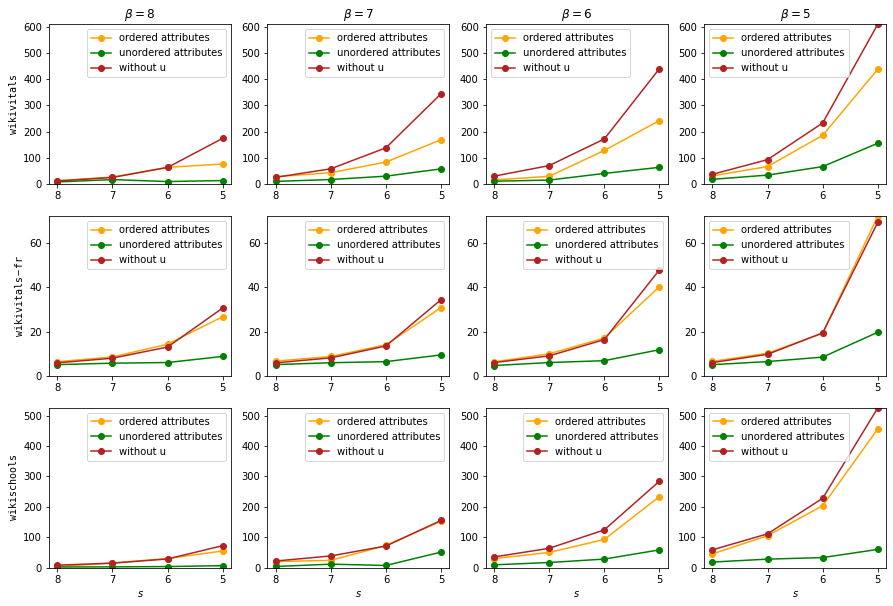

In [360]:
betas = ['beta_8', 'beta_7', 'beta_6', 'beta_5']
orderings = ['ordered attributes', 'unordered attributes', 'without u']
colors = ['orange', 'green', 'firebrick']
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']

fig, ax = plt.subplots(len(datasets), len(betas), figsize=(15, 10))

for d, dataset in enumerate(datasets):
    max_y = 0
    for i, b in enumerate(betas):
        for j, o in enumerate(orderings):
            vals = logs.get(dataset).get(o).get(b)
            ax[d, i].plot(vals, marker='o', label=o, color=colors[j])
            ax[d, i].set_xticks(np.arange(0, len(betas)), labels=['8', '7', '6', '5'])
            ax[d, i].legend()
            beta = b.split('_')[1]
            if d == 0:
                ax[d, i].set_title(rf"$\beta={beta}$")
            if d == len(datasets) - 1:
                ax[d, i].set_xlabel('$s$')
            max_y = max(max_y, np.max(vals))
            
    for k in range(len(betas)):
        ax[d, k].set_ylim(0, max_y)
        
    ax[d, 0].set_ylabel(rf"$\tt{dataset}$")
    
# Save image
plt.savefig('../output/img/attribute_ordering.eps', dpi=200, bbox_inches='tight')

**Compressed Figure**

In [365]:
import matplotlib
matplotlib.colors.to_rgb('dodgerblue')

(0.11764705882352941, 0.5647058823529412, 1.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


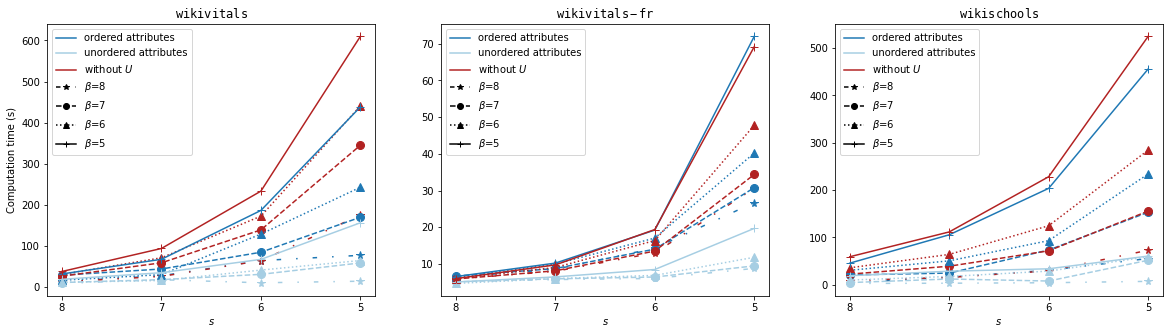

In [372]:
from matplotlib.lines import Line2D

betas = ['beta_8', 'beta_7', 'beta_6', 'beta_5']
orderings = ['ordered attributes', 'unordered attributes', 'without u']
colors = ['#1f78b4', '#a6cee3', 'firebrick']
markers = ['*', 'o', '^', '+']
styles = [(0, (3, 10, 1, 10)), 'dashed', 'dotted', 'solid']
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']

fig, ax = plt.subplots(1, len(datasets), figsize=(20, 5))

legend_elements = [Line2D([0], [0], color=colors[0], label='ordered attributes'),
                   Line2D([0], [0], color=colors[1], label=r'unordered attributes'),
                   Line2D([0], [0], color=colors[2], label=r'without $U$'),
                   Line2D([0], [0], color='black', marker='*', linestyle=styles[0], label=r'$\beta$=8'),
                   Line2D([0], [0], color='black', marker='o', linestyle=styles[1], label=r'$\beta$=7'),
                   Line2D([0], [0], color='black', marker='^', linestyle=styles[2], label=r'$\beta$=6'),
                   Line2D([0], [0], color='black', marker='+', linestyle=styles[3], label=r'$\beta$=5'),
                   ]

for d, dataset in enumerate(datasets):
    max_y = 0
    for i, b in enumerate(betas):
        for j, o in enumerate(orderings):
            vals = logs.get(dataset).get(o).get(b)
            ax[d].plot(vals, marker=markers[i], linestyle=styles[i], label=o, color=colors[j], markersize=8)
            ax[d].legend(handles=legend_elements)
    ax[d].set_title(rf"$\tt{dataset}$")
    ax[d].set_xlabel(r'$s$')
    ax[d].set_xticks(np.arange(0, len(betas)), labels=['8', '7', '6', '5'])
    if d == 0:
        ax[d].set_ylabel('Computation time (s)')
        
# Save image
plt.savefig('../output/img/computation_times.eps', dpi=200, bbox_inches='tight')

### Cover rate according to number of patterns

We measure the cover rate w.r.t. $|V|$ according to the number of patterns, as well as the ordering of attributes.  
**Hypothesis:** the cover rate should be higher with the ordering of attributes.

In [373]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
betas = [8, 7, 6, 5]
ss = [8, 7, 6, 5]
with_order = [True, False]
cover_rates = defaultdict()

for d, dataset in enumerate(datasets):
    max_y = 0
    cover_rates[dataset] = defaultdict(dict)
    for i, b in enumerate(betas):
        for k, s in enumerate(ss):
            with open(f"../output/result/result_{dataset}_{b}_{s}_orderTrue.bin", "rb") as data:
                res_ord = pickle.load(data)
            with open(f"../output/result/result_{dataset}_{b}_{s}_orderFalse.bin", "rb") as data:
                res_not_ord = pickle.load(data)
            with open(f"../output/result/without_u/result_{dataset}_{b}_{s}_orderTrue_without_constraint.bin", "rb") as data:
                res_without_u = pickle.load(data)
            
            n = len(res_ord[0][0]) # number of nodes in dataset
            
            nodes_ord = set()
            for c in res_ord:
                if len(c[1]) > 0:
                    nodes_ord |= set(c[0])
                    
            nodes_not_ord = set()
            for c in res_not_ord:
                if len(c[1]) > 0:
                    nodes_not_ord |= set(c[0])
                    
            nodes_without_u = set()
            for c in res_without_u:
                if len(c[1]) > 0:
                    nodes_without_u |= set(c[0])
            
            cover_rate_ord = len(nodes_ord) / n
            nb_patterns_ord = len(res_ord)
            cover_rate_not_ord = len(nodes_not_ord) / n
            nb_patterns_not_ord = len(res_not_ord)
            cover_rate_without_u = len(nodes_without_u) / n
            nb_patterns_without_u = len(res_without_u)
            cover_rates[dataset]['ord'][nb_patterns_ord] = cover_rate_ord
            cover_rates[dataset]['not_ord'][nb_patterns_not_ord] = cover_rate_not_ord
            cover_rates[dataset]['without u'][nb_patterns_without_u] = cover_rate_without_u

**Plot results**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


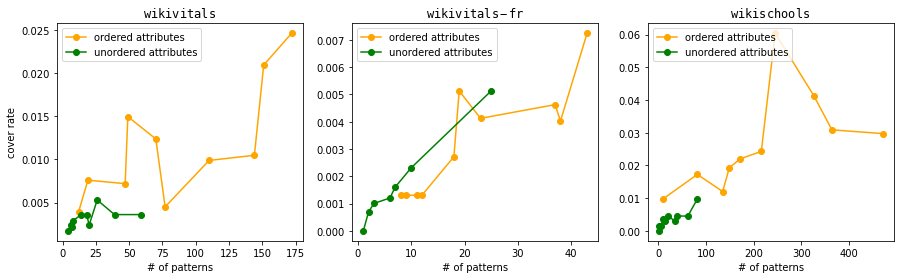

In [1212]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for d, dataset in enumerate(datasets):
    sort_vals = dict(sorted(cover_rates.get(dataset).get('ord').items()))
    not_sort_vals = dict(sorted(cover_rates.get(dataset).get('not_ord').items()))
    ax[d].plot(list(sort_vals.keys())[:10], list(sort_vals.values())[:10], label='ordered attributes', color='orange', marker='o')
    ax[d].plot(list(not_sort_vals.keys())[:10], list(not_sort_vals.values())[:10], label='unordered attributes', color='green', marker='o')
    ax[d].legend(loc='upper left')
    ax[d].set_title(rf'$\tt{dataset}$')
    ax[d].set_xlabel(rf'# of patterns')
ax[0].set_ylabel(rf'cover rate')

# Save image
plt.savefig('../output/img/cover_rate.eps', dpi=200, bbox_inches='tight')

### Cumulated cover rate over algorithm iterations

For each new pattern found by the algorithm, we compute the cumulated number of distinct nodes in patterns and divide it to the total number of nodes in the original graph to obtain the **cover rates as a function of the number of patterns**.
We distinguish the analysis according the presence of ordering of attributes or not.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.082809, 0.0149, 0.082809
0.032579, 0.0051, 0.032579
0.152169, 0.0279, 0.152169


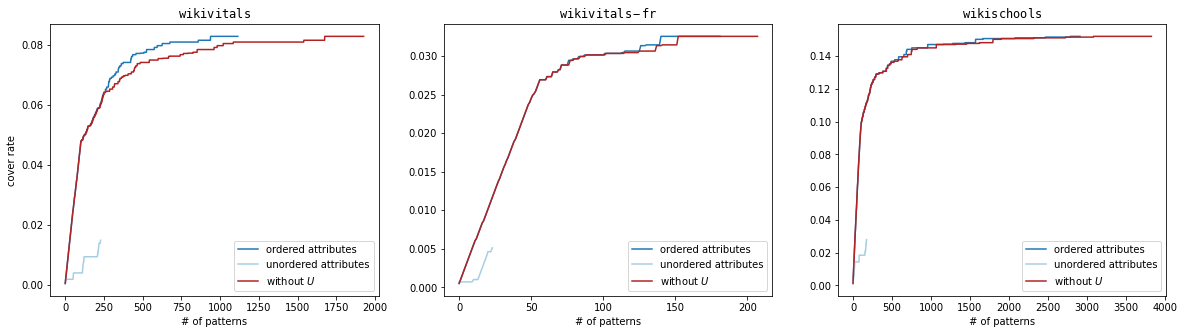

In [381]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

colors = ['#1f78b4', '#a6cee3', 'firebrick']
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
betas = [5]
ss = [5]
cover_rates = defaultdict()

for d, dataset in enumerate(datasets):
    max_y = 0
    cover_rates[dataset] = defaultdict(dict)
    for i, b in enumerate(betas):
        for k, s in enumerate(ss):
            with open(f"../output/result/result_{dataset}_{b}_{s}_orderTrue.bin", "rb") as data:
                res_ord = pickle.load(data)
            with open(f"../output/result/result_{dataset}_{b}_{s}_orderFalse.bin", "rb") as data:
                res_not_ord = pickle.load(data)
            with open(f"../output/result/without_u/result_{dataset}_{b}_{s}_orderTrue_without_constraint.bin", "rb") as data:
                res_without_u = pickle.load(data)
            
            n = len(res_ord[0][0]) # number of nodes in dataset
            
            nodes_ord = set()
            cum_nb_nodes_ord = []
            for p1 in res_ord:
                if len(p1[1]) > 0:
                    nodes_ord |= set(p1[0])
                    cum_nb_nodes_ord.append(len(nodes_ord))
                    
            nodes_not_ord = set()
            cum_nb_nodes_not_ord = []
            for p2 in res_not_ord:
                if len(p2[1]) > 0:
                    nodes_not_ord |= set(p2[0])
                    cum_nb_nodes_not_ord.append(len(nodes_not_ord))
                    
            nodes_without_u = set()
            cum_nb_nodes_without_u = []
            for p3 in res_without_u:
                if len(p3[1]) > 0:
                    nodes_without_u |= set(p3[0])
                    cum_nb_nodes_without_u.append(len(nodes_without_u))

            cover_rate_ord = np.array(cum_nb_nodes_ord) / n
            cover_rate_not_ord = np.array(cum_nb_nodes_not_ord) / n
            cover_rate_without_u = np.array(cum_nb_nodes_without_u) / n
            print(f'{max(cover_rate_ord):.6f}, {max(cover_rate_not_ord):.4f}, {max(cover_rate_without_u):.6f}')
            
            ax[d].plot(cover_rate_ord, label='ordered attributes', color=colors[0])
            ax[d].plot(cover_rate_not_ord, label='unordered attributes', color=colors[1])
            ax[d].plot(cover_rate_without_u, label=rf'without $U$', color=colors[2])
            ax[d].legend(loc='lower right')
            ax[d].set_xlabel('# of patterns')
            ax[d].set_title(rf'$\tt{dataset}$')
            if d == 0:
                ax[d].set_ylabel('cover rate')
                
# Save image
plt.savefig('../output/img/cover_rates_nb_attributes.eps', dpi=200, bbox_inches='tight')

In [2278]:
dataset= 'wikivitals'
b = 5
s = 5
with open(f"../output/result/result_{dataset}_{b}_{s}_orderTrue.bin", "rb") as data:
    res_ord = pickle.load(data)
len(res_ord)

1116

### Number of patterns with/without using Unexpectedness measure

We run the UnexPAttern algorithm without unexpectedness constraint and compare number of patterns found with result using unexpectedness.

In [54]:
# Without unexpectedness
import pickle


with open('../output/log/without_u/number_of_patterns_history.pkl', 'rb') as f:
    history = pickle.load(f)

history

defaultdict(dict,
            {'wikivitals': defaultdict(dict,
                         {False: defaultdict(list,
                                      {8: [6, 20, 52, 114],
                                       7: [7, 27, 78, 186],
                                       6: [7, 27, 78, 187],
                                       5: [27, 74, 168, 365]}),
                          True: defaultdict(list,
                                      {8: [12, 53, 175, 480],
                                       7: [79, 207, 492, 1080],
                                       6: [94, 249, 603, 1379],
                                       5: [126, 341, 829, 1928]})}),
             'wikivitals-fr': defaultdict(dict,
                         {False: defaultdict(list,
                                      {8: [1, 2, 4, 14],
                                       7: [1, 2, 4, 15],
                                       6: [1, 2, 5, 19],
                                       5: [1, 3, 9, 35]}),
    

In [55]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
betas = [8, 7, 6, 5]
ss = [8, 7, 6, 5]
with_order = [True, False]
nb_pattern_dict = defaultdict(dict)

for d, dataset in enumerate(datasets):
    nb_pattern_dict[dataset] = defaultdict(dict)
    for attr_ord in with_order:
        nb_pattern_dict[dataset][attr_ord] = defaultdict(list)
        for b in betas:
            for s in ss:

                with open(f"../output/result/result_{dataset}_{b}_{s}_order{attr_ord}.bin", "rb") as data:
                    res = pickle.load(data)
            
                # Save number of patterns
                nb_pattern_dict[dataset][attr_ord][b].append(len(res))
                
with open(f'../output/log/number_of_patterns_history.pkl', 'wb') as f:
    pickle.dump(nb_pattern_dict, f)

In [369]:
# Load data with U
with open(f'../output/log/number_of_patterns_history.pkl', 'rb') as data:
    nb_pattern_dict = pickle.load(data)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


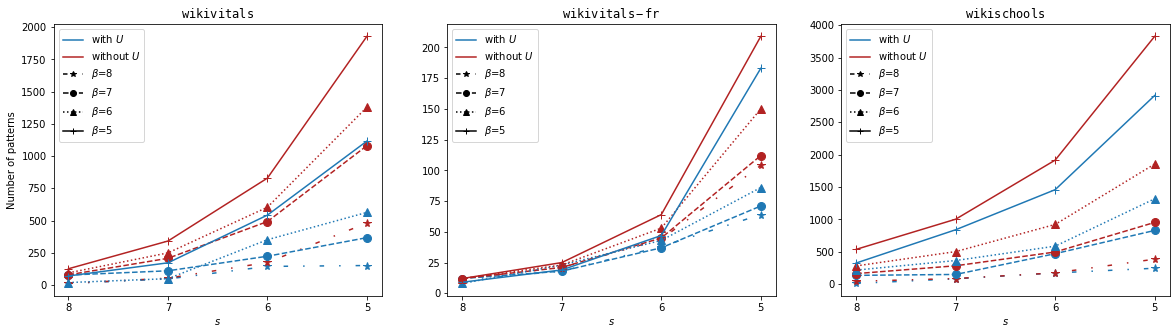

In [371]:
from matplotlib.lines import Line2D

betas = [8, 7, 6, 5]
betas_log = ['beta_8', 'beta_7', 'beta_6', 'beta_5']
ticks_labels = ['8', '7', '6', '5']
with_unex = [True, False]
colors = ['#1f78b4', 'firebrick']
markers = ['*', 'o', '^', '+']
styles = [(0, (3, 10, 1, 10)), 'dashed', 'dotted', 'solid']
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']

fig, ax = plt.subplots(1, len(datasets), figsize=(20, 5))

legend_elements = [Line2D([0], [0], color=colors[0], label='with $U$'),
                   Line2D([0], [0], color=colors[1], label=r'without $U$'),
                   Line2D([0], [0], color='black', marker='*', linestyle=styles[0], label=r'$\beta$=8'),
                   Line2D([0], [0], color='black', marker='o', linestyle=styles[1], label=r'$\beta$=7'),
                   Line2D([0], [0], color='black', marker='^', linestyle=styles[2], label=r'$\beta$=6'),
                   Line2D([0], [0], color='black', marker='+', linestyle=styles[3], label=r'$\beta$=5'),
                   ]

for d, dataset in enumerate(datasets):
    max_y = 0
    for i, b in enumerate(betas):
        for j, u in enumerate(with_unex):
            if u:
                vals = nb_pattern_dict.get(dataset).get(True).get(b)
                lab = rf'with $U$'
            else:
                vals = history.get(dataset).get(True).get(b)
                lab = rf'without $U$'
            ax[d].plot(vals, marker=markers[i], linestyle=styles[i], label=lab, color=colors[j], markersize=8)
            #ax[d].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
            ax[d].legend(handles=legend_elements)
            #beta = str(b) #b.split('_')[1]
    ax[d].set_title(rf"$\tt{dataset}$")
    ax[d].set_xlabel(r'$s$')
    ax[d].set_xticks(np.arange(0, len(betas)), labels=['8', '7', '6', '5'])
    if d == 0:
        ax[d].set_ylabel('Number of patterns')
            
# Save image
plt.savefig('../output/img/unexpectedness_ablation_small.eps', dpi=200, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


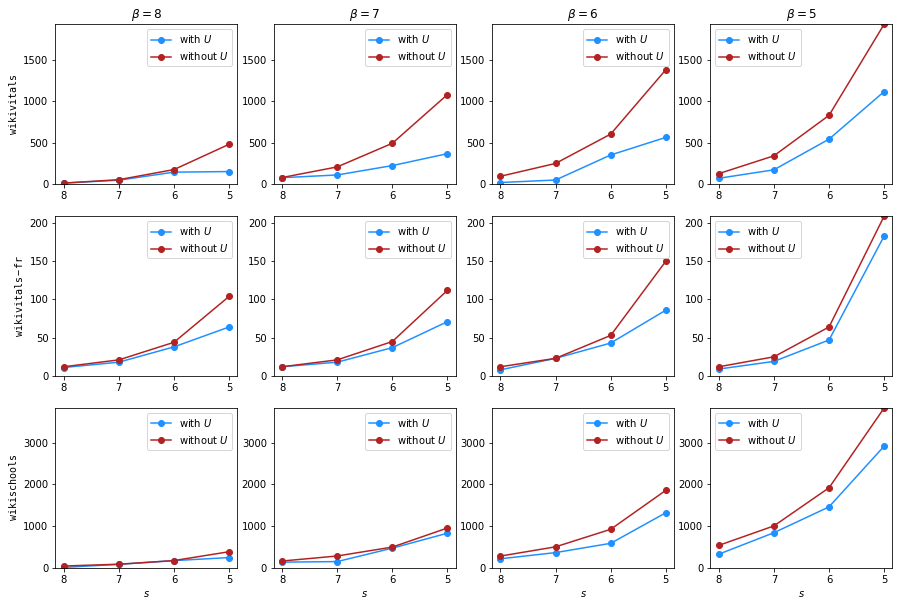

In [2288]:
betas = [8, 7, 6, 5]
betas_log = ['beta_8', 'beta_7', 'beta_6', 'beta_5']
ticks_labels = ['8', '7', '6', '5']
with_unex = [True, False]
colors = ['dodgerblue', 'firebrick']
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']

fig, ax = plt.subplots(len(datasets), len(betas), figsize=(15, 10))

for d, dataset in enumerate(datasets):
    max_y = 0
    for i, b in enumerate(betas):
        for j, u in enumerate(with_unex):
            if u:
                vals = nb_pattern_dict.get(dataset).get(True).get(b)
                lab = rf'with $U$'
            else:
                vals = history.get(dataset).get(True).get(b)
                lab = rf'without $U$'
            ax[d, i].plot(vals, marker='o', label=lab, color=colors[j])
            ax[d, i].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
            ax[d, i].legend()
            beta = str(b) #b.split('_')[1]
            if d == 0:
                ax[d, i].set_title(rf"$\beta={beta}$")
            if d == len(datasets) - 1:
                ax[d, i].set_xlabel('$s$')
            max_y = max(max_y, np.max(vals))
            
    for k in range(len(betas)):
        ax[d, k].set_ylim(0, max_y)
        
    ax[d, 0].set_ylabel(rf"$\tt{dataset}$")
    
# Save image
plt.savefig('../output/img/unexpectedness_ablation.eps', dpi=200, bbox_inches='tight')

## RQ2: How our algorithm can help avoid redundancy in patterns?

### Using word/doc embedding models for redundancy analysis

* We consider each Wikipedia article as a document containing words, and train a document embedding model using `Doc2Vec`  
* We use our trained model to infer embeddings for new documents, i.e patterns/concepts/communities  
* We compute distances between these embeddings using **Wasserstein distance**

**1. Doc2Vec model training**

In [ ]:
%%time

# Doc2Vec model on whole biadjacency matrix
corpus = list(MyCorpus(biadjacency, orig_words))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=10, epochs=100)
model.build_vocab(corpus)

# Training model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

**2. Infer patterns embeddings and compute pairwise Wasserstein distances**

In [1214]:
def d2v_embedding(model, doc):
    """Use pre-trained model to embed document."""
    return model.infer_vector(doc)

def pairwise_wd_distance(matrix, n, model, names):
    """Pairwise Wasserstein distances between elements in matrix."""

    wd_matrix = np.zeros((n, n))
    
    for i in range(n):
        w1 = d2v_embedding(model, names[np.flatnonzero(matrix[i, :])])
        for j in range(n):
            w2 = d2v_embedding(model, names[np.flatnonzero(matrix[j, :])])
            wd_matrix[i, j] = wasserstein_distance(w1, w2)
            
    return wd_matrix

In [2290]:
# Load result
with open("../output/result/average_wasserstein_distances_all.pkl", "rb") as data:
    avg_wassertein_distances = pickle.load(data)

**Statitics on results**

In [ ]:
# concept_attributes matrices contains numerical data instead of binary
# Doc2Vec embedding of matrices instead of Spectral embedding
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
betas = [8, 7, 6, 5]
ss = [8, 7, 6, 5]
markers = ['o', '*', 's', 'p', '|', '1']

fig, ax = plt.subplots(len(datasets), len(betas), figsize=(15, 10))

for d, dataset in enumerate(datasets):

    for j, b in enumerate(betas):
    
        vals_concepts = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('concepts')[0] for s in ss]
        vals_summarized = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('summarized')[0] for s in ss]
        vals_louvain = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('louvain')[0] for s in ss]
        vals_spectral = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('spectral_kmeans')[0] for s in ss]
        vals_gnn = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('gnn_kmeans')[0] for s in ss]
        vals_doc2vec = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('doc2vec_kmeans')[0] for s in ss]

        sns.boxplot(vals_concepts)ax[d, j].plot(vals_concepts, label='patterns', marker=markers[0], linestyle='dashed')
        ax[d, j].plot(vals_summarized, label='summaries', marker=markers[1])
        ax[d, j].plot(vals_louvain, label='louvain', marker=markers[2])
        ax[d, j].plot(vals_spectral, label='spectral', marker=markers[3])
        ax[d, j].plot(vals_gnn, label='GNN', marker=markers[4])
        ax[d, j].plot(vals_doc2vec, label='doc2vec', marker=markers[5])
        ax[d, j].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
        if d == 0:
            ax[d, j].set_title(rf'$\beta={b}$')
        ax[d, j].legend(loc='lower left')
        if d == 2:
            ax[d, j].set_xlabel('s')
            
    for k in range(len(betas)):
        ax[d, k].set_ylim(min_y, max_y+0.01)

for i in range(len(datasets)):
    ax[i, 0].set_ylabel(rf'$\tt{datasets[i]}$')
    
# Save figure
#plt.savefig('../output/img/wd_distances_concepts_d2vmodel.eps', dpi=200, bbox_inches='tight')

**Plot results**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


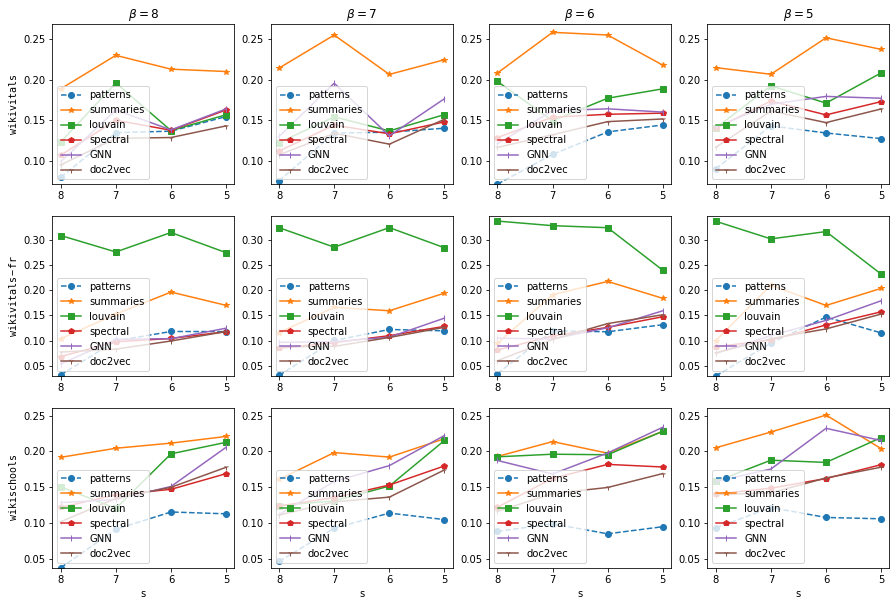

In [1217]:
# concept_attributes matrices contains numerical data instead of binary
# Doc2Vec embedding of matrices instead of Spectral embedding
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
betas = [8, 7, 6, 5]
ss = [8, 7, 6, 5]
markers = ['o', '*', 's', 'p', '|', '1']

fig, ax = plt.subplots(len(datasets), len(betas), figsize=(15, 10))

for d, dataset in enumerate(datasets):
    min_y = np.inf
    max_y = 0
    for j, b in enumerate(betas):
    
        vals_concepts = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('concepts')[0] for s in ss]
        vals_summarized = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('summarized')[0] for s in ss]
        vals_louvain = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('louvain')[0] for s in ss]
        vals_spectral = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('spectral_kmeans')[0] for s in ss]
        vals_gnn = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('gnn_kmeans')[0] for s in ss]
        vals_doc2vec = [avg_wassertein_distances.get(dataset).get(int(b)).get(s).get('doc2vec_kmeans')[0] for s in ss]

        min_y = min(min_y, min(np.min(vals_concepts), np.min(vals_summarized), np.min(vals_louvain), np.min(vals_spectral),
                   np.min(vals_gnn), np.min(vals_doc2vec)))
        max_y = max(max_y, max(np.max(vals_concepts), np.max(vals_summarized), np.max(vals_louvain), np.max(vals_spectral),
                   np.max(vals_gnn), np.max(vals_doc2vec)))

        ax[d, j].plot(vals_concepts, label='patterns', marker=markers[0], linestyle='dashed')
        ax[d, j].plot(vals_summarized, label='summaries', marker=markers[1])
        ax[d, j].plot(vals_louvain, label='louvain', marker=markers[2])
        ax[d, j].plot(vals_spectral, label='spectral', marker=markers[3])
        ax[d, j].plot(vals_gnn, label='GNN', marker=markers[4])
        ax[d, j].plot(vals_doc2vec, label='doc2vec', marker=markers[5])
        ax[d, j].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
        if d == 0:
            ax[d, j].set_title(rf'$\beta={b}$')
        ax[d, j].legend(loc='lower left')
        if d == 2:
            ax[d, j].set_xlabel('s')
            
    for k in range(len(betas)):
        ax[d, k].set_ylim(min_y, max_y+0.01)

for i in range(len(datasets)):
    ax[i, 0].set_ylabel(rf'$\tt{datasets[i]}$')
    
#ax[0].set_ylabel('Average pairwise Wasserstein distance');
#plt.legend(bbox_to_anchor=(1., 3.435), loc='upper left');
plt.savefig('../output/img/wd_distances_concepts_d2vmodel.eps', dpi=200, bbox_inches='tight')

### Different representation for Wasserstein distances

Instead of plotting **average** Wasserstein distances, we plot boxplots of pairwise distance values.  
We fix $s$ and $\beta$ equal to $5$.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


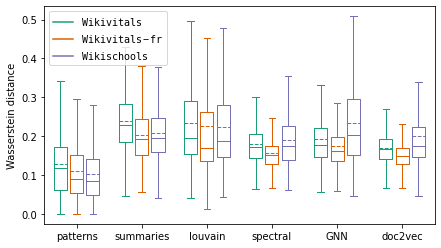

In [2719]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
xlabels = {'concepts': 'patterns', 'summaries': 'summaries', 'louvain': 'louvain', 'spectral_kmeans': 'spectral', 'gnn_kmeans': 'GNN',
           'd2v_kmeans': 'doc2vec'}
s = 5
beta = 5

pairwise_distances = defaultdict(list)
    
for dataset in datasets:
    
    # Load pairwise distance matrices 
    for method in xlabels.keys():
        with open(f'../output/result/wasserstein_distances_{dataset}_{beta}_{s}_{method}.pkl', 'rb') as data:
            d2v_wd_data = np.load(data).ravel()
            
        # Store data
        pairwise_distances[dataset].append(d2v_wd_data)
        
# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

bpl = plt.boxplot(pairwise_distances.get('wikivitals'), positions=np.array(range(len(pairwise_distances.get('wikivitals'))))*2.0-0.5, sym='', widths=0.4, meanline=True, showmeans=True)
bpm = plt.boxplot(pairwise_distances.get('wikivitals-fr'), positions=np.array(range(len(pairwise_distances.get('wikivitals-fr'))))*2.0, sym='', widths=0.4, meanline=True, showmeans=True)
bpr = plt.boxplot(pairwise_distances.get('wikischools'), positions=np.array(range(len(pairwise_distances.get('wikischools'))))*2.0+0.5, sym='', widths=0.4, meanline=True, showmeans=True)
set_box_color(bpl, '#1b9e77')
set_box_color(bpm, '#d95f02')
set_box_color(bpr, '#7570b3')

plt.xticks(range(0, len(xlabels.values()) * 2, 2), xlabels.values())

#plt.yscale('log')
ax.set_xticklabels(xlabels.values())
plt.ylabel('Wasserstein distance')

plt.plot([], c='#1b9e77', label=r'$\tt{Wikivitals}$')
plt.plot([], c='#d95f02', label=r'$\tt{Wikivitals-fr}$')
plt.plot([], c='#7570b3', label=r'$\tt{Wikischools}$')
plt.legend(loc='upper left')

# Save figure
plt.savefig('../output/img/wd_distances_boxplots.eps', dpi=200, bbox_inches='tight')

### Other statistics for baseline comparisons. 

We fix parameters $s$ and $\beta$ to $5$.
For each dataset, we compare:
* extent sizes
* intent sizes
* graph density

**Extent size**

In [2714]:
with open(f'../output/result/extent_sizes.pkl', 'rb') as data:
    extent_sizes = pickle.load(data)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


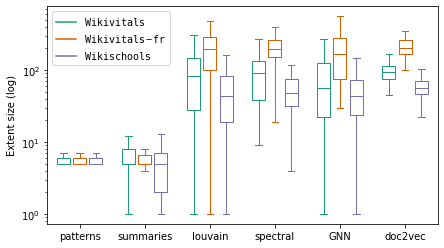

In [2715]:
xlabels = {'patterns': 'patterns', 'summaries': 'summaries', 'louvain': 'louvain', 'spectral': 'spectral', 'gnn': 'GNN', 'doc2vec': 'doc2vec'}
s = 5
beta = 5

# Get data
data_wikivitals = [extent_sizes.get('wikivitals').get(beta).get(s).get(key) for key in xlabels.keys()]
data_wikivitals_fr = [extent_sizes.get('wikivitals-fr').get(beta).get(s).get(key) for key in xlabels.keys()]
data_wikischools = [extent_sizes.get('wikischools').get(beta).get(s).get(key) for key in xlabels.keys()]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

bpl = plt.boxplot(data_wikivitals, positions=np.array(range(len(data_wikivitals)))*2.0-0.5, sym='', widths=0.4)
bpm = plt.boxplot(data_wikivitals_fr, positions=np.array(range(len(data_wikivitals_fr)))*2.0, sym='', widths=0.4)
bpr = plt.boxplot(data_wikischools, positions=np.array(range(len(data_wikischools)))*2.0+0.5, sym='', widths=0.4)
set_box_color(bpl, '#1b9e77')
set_box_color(bpm, '#d95f02')
set_box_color(bpr, '#7570b3')

plt.xticks(range(0, len(xlabels.values()) * 2, 2), xlabels.values())

plt.yscale('log')
ax.set_xticklabels(xlabels.values())
plt.ylabel('Extent size (log)')

plt.plot([], c='#1b9e77', label=r'$\tt{Wikivitals}$')
plt.plot([], c='#d95f02', label=r'$\tt{Wikivitals-fr}$')
plt.plot([], c='#7570b3', label=r'$\tt{Wikischools}$')
plt.legend()

plt.savefig('../output/img/extent_sizes_boxplots.eps', dpi=200, bbox_inches='tight');

**Intent size**

In [2712]:
with open(f'../output/result/intent_sizes.pkl', 'rb') as data:
    intent_sizes = pickle.load(data)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


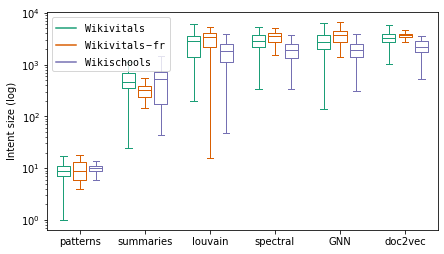

In [2717]:
xlabels = {'patterns': 'patterns', 'summaries': 'summaries', 'louvain': 'louvain', 'spectral': 'spectral', 'gnn': 'GNN', 'doc2vec': 'doc2vec'}
s = 5
beta = 5

# Get data
data_wikivitals = [intent_sizes.get('wikivitals').get(beta).get(s).get(key) for key in xlabels.keys()]
data_wikivitals_fr = [intent_sizes.get('wikivitals-fr').get(beta).get(s).get(key) for key in xlabels.keys()]
data_wikischools = [intent_sizes.get('wikischools').get(beta).get(s).get(key) for key in xlabels.keys()]
    
# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

bpl = plt.boxplot(data_wikivitals, positions=np.array(range(len(data_wikivitals)))*2.0-0.5, sym='', widths=0.4)
bpm = plt.boxplot(data_wikivitals_fr, positions=np.array(range(len(data_wikivitals_fr)))*2.0, sym='', widths=0.4)
bpr = plt.boxplot(data_wikischools, positions=np.array(range(len(data_wikischools)))*2.0+0.5, sym='', widths=0.4)
set_box_color(bpl, '#1b9e77')
set_box_color(bpm, '#d95f02')
set_box_color(bpr, '#7570b3')

plt.xticks(range(0, len(xlabels.values()) * 2, 2), xlabels.values())

plt.yscale('log')
ax.set_xticklabels(xlabels.values())
plt.ylabel('Intent size (log)')

plt.plot([], c='#1b9e77', label=r'$\tt{Wikivitals}$')
plt.plot([], c='#d95f02', label=r'$\tt{Wikivitals-fr}$')
plt.plot([], c='#7570b3', label=r'$\tt{Wikischools}$')
plt.legend(loc='upper left')

plt.savefig('../output/img/intent_sizes_boxplots.eps', dpi=200, bbox_inches='tight');

**Densities**

In [2706]:
with open(f'../output/result/densities.pkl', 'rb') as data:
    densities = pickle.load(data)

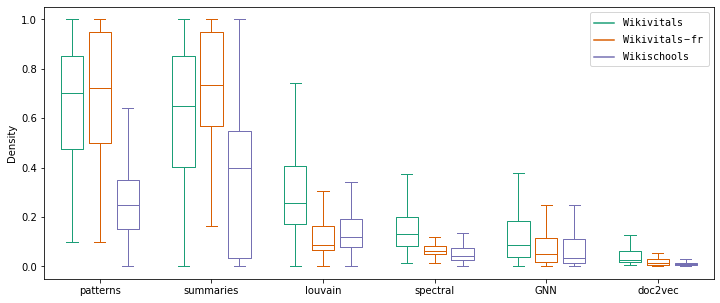

In [2698]:
xlabels = {'patterns': 'patterns', 'summaries': 'summaries', 'louvain': 'louvain', 'spectral': 'spectral', 'gnn': 'GNN', 'doc2vec': 'doc2vec'}
s = 5
beta = 5

# Get data
data_wikivitals = [densities.get('wikivitals').get(beta).get(s).get(key) for key in xlabels.keys()]
data_wikivitals_fr = [densities.get('wikivitals-fr').get(beta).get(s).get(key) for key in xlabels.keys()]
data_wikischools = [densities.get('wikischools').get(beta).get(s).get(key) for key in xlabels.keys()]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

bpl = plt.boxplot(data_wikivitals, positions=np.array(range(len(data_wikivitals)))*2.0-0.5, sym='', widths=0.4)
bpm = plt.boxplot(data_wikivitals_fr, positions=np.array(range(len(data_wikivitals_fr)))*2.0, sym='', widths=0.4)
bpr = plt.boxplot(data_wikischools, positions=np.array(range(len(data_wikischools)))*2.0+0.5, sym='', widths=0.4)
set_box_color(bpl, '#1b9e77')
set_box_color(bpm, '#d95f02')
set_box_color(bpr, '#7570b3')

plt.xticks(range(0, (len(xlabels.values())) * 2, 2), list(xlabels.values()))

#plt.yscale('log')
ax.set_xticklabels(list(xlabels.values()))
plt.ylabel('Density')

plt.plot([], c='#1b9e77', label=r'$\tt{Wikivitals}$')
plt.plot([], c='#d95f02', label=r'$\tt{Wikivitals-fr}$')
plt.plot([], c='#7570b3', label=r'$\tt{Wikischools}$')
plt.legend()

#plt.savefig('../output/img/wd_distances_boxplots.eps', dpi=200, bbox_inches='tight');

**$k$-core decomposition** 

We compare the $k$-core distributions of the patterns/communities.

In [2707]:
with open(f'../output/result/kcores.pkl', 'rb') as data:
    kcores = pickle.load(data)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


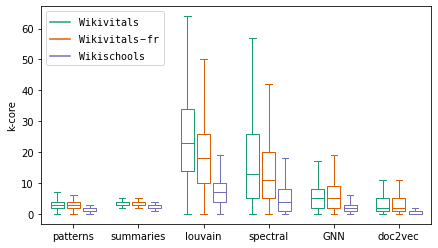

In [2711]:
xlabels = {'patterns': 'patterns', 'summaries': 'summaries', 'louvain': 'louvain', 'spectral': 'spectral', 'gnn': 'GNN', 'doc2vec': 'doc2vec'}
#xlabels = {'louvain': 'louvain', 'spectral': 'spectral', 'gnn': 'GNN', 'doc2vec': 'doc2vec'}
s = 5
beta = 5

# Get data
data_wikivitals = [kcores.get('wikivitals').get(beta).get(s).get(key) for key in xlabels.keys()]
data_wikivitals_fr = [kcores.get('wikivitals-fr').get(beta).get(s).get(key) for key in xlabels.keys()]
data_wikischools = [kcores.get('wikischools').get(beta).get(s).get(key) for key in xlabels.keys()]
    
# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

bpl = plt.boxplot(data_wikivitals, positions=np.array(range(len(data_wikivitals)))*2.0-0.5, sym='', widths=0.4)
bpm = plt.boxplot(data_wikivitals_fr, positions=np.array(range(len(data_wikivitals_fr)))*2.0, sym='', widths=0.4)
bpr = plt.boxplot(data_wikischools, positions=np.array(range(len(data_wikischools)))*2.0+0.5, sym='', widths=0.4)
set_box_color(bpl, '#1b9e77')
set_box_color(bpm, '#d95f02')
set_box_color(bpr, '#7570b3')

plt.xticks(range(0, (len(xlabels.values())) * 2, 2), list(xlabels.values()))

#plt.yscale('log')
ax.set_xticklabels(list(xlabels.values()))
plt.ylabel('k-core')

plt.plot([], c='#1b9e77', label=r'$\tt{Wikivitals}$')
plt.plot([], c='#d95f02', label=r'$\tt{Wikivitals-fr}$')
plt.plot([], c='#7570b3', label=r'$\tt{Wikischools}$')
plt.legend(loc='upper left')

plt.savefig('../output/img/kcores_boxplots.eps', dpi=200, bbox_inches='tight');

**Draw pattern summaries**

In [2691]:
dataset = 'wikivitals'
b = 5
s = 5
sorted_attributes = True

filename = f'result_{dataset}_{b}_{s}_order{str(sorted_attributes)}'
with open(f'../output/result/{filename}.bin', 'rb') as data:
    test = pickle.load(data)

# Load and preprocess data
graph = load_netset(dataset)
adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels
orig_words = words.copy()

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
if sorted_attributes:
    sort_index = np.argsort(freq_attribute)
else:
    sort_index = np.arange(0, len(freq_attribute))
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

# Graph summarization
# ------------------------------------------------------------------
summarized_adjacency = get_summarized_graph(adjacency, test)

# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))

# Number of connected components NOT considering isolated nodes
labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
nb_cc = len(np.unique(labels_cc_summarized)) 
print(nb_cc)

summarized_biadjacency = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
for c in test:
    if len(c[1]) > 0:
        for node in c[0]:
            summarized_biadjacency[node, c[1]] += 1
summarized_biadjacency = sparse.csr_matrix(summarized_biadjacency.astype(bool), shape=summarized_biadjacency.shape)

Parsing files...
Done.
101


In [2694]:
louvain = Louvain(resolution=4.47) 
labels_louvain = louvain.fit_transform(adjacency)

mycom = labels_louvain == 0

core = CoreDecomposition()
mylabs = core.fit_transform(adjacency[mycom, :][:, mycom])
mylabs
#SVG(svg_graph(adjacency[mycom, :][:, mycom]))

array([23, 19, 17,  5, 18,  8, 11, 12, 20, 44, 16, 25, 30, 27, 16, 26, 17,
       17,  9, 28,  7, 19, 29, 18, 21, 12, 17, 11, 17,  9, 30, 28, 16, 14,
       18,  6, 26, 11, 23, 17, 31,  7, 20, 17, 22, 20, 15, 23, 19, 15,  8,
       18, 16, 14, 12, 13, 16, 16, 17, 31,  9, 16,  6, 20,  5, 29, 20, 14,
       13, 12, 12, 15, 17, 31, 29, 14, 12,  6, 31, 15, 14, 26, 16, 21, 12,
       25, 19,  7, 17, 31, 21, 16, 15, 16,  8, 19, 10, 16, 17, 10, 21, 19,
       32, 14,  9,  5, 24, 21, 57, 11, 20,  8, 17, 19, 18, 31, 31,  2, 17,
       30, 17, 34, 17, 23, 19, 12, 30,  3, 14, 18, 17, 19, 26, 23, 12, 19,
       18, 27, 23, 23, 38, 23,  1, 32, 13, 20, 13,  9,  8, 31, 31, 13, 20,
       19,  3, 31, 13, 20,  7, 15, 19, 32,  9,  9, 26, 15, 17, 12, 13, 21,
       31,  8, 12, 16, 19, 28, 22, 21, 12, 29, 23, 23,  9, 16, 30, 13, 15,
       21, 15, 16, 31, 17, 18, 12, 19,  0, 12, 12,  7, 11, 20, 16, 21, 30,
       36, 11, 11, 19, 15,  9,  8, 19, 19, 14, 14, 16,  9, 16,  9, 31,  8,
       14, 14,  9,  8, 21

* China empire related summary : idx = 1
* Sport summary : idx = 12
* Music summary : idx = 11
* Indian empire : idx = 14
* Diseases/sexuality : idx = 16
* logic : idx = 17
* Astrophysics : idx = 22
* Space mission : idx = 28
* Opera : idx = 31
* Colors : idx = 49

['1911 Revolution' 'Along the River During the Qingming Festival'
 'Changchun' 'Empress Dowager Cixi' 'Harbin' 'Manchuria' 'Puyi'
 'Qing dynasty' 'Second Sino-Japanese War' 'Shenyang']
{'chinese', 'japanese', 'Puyi', 'Manchukuo', 'capital', 'puppet', 'China', 'Japanese', 'dynasty', 'Chinese', 'Qing'}


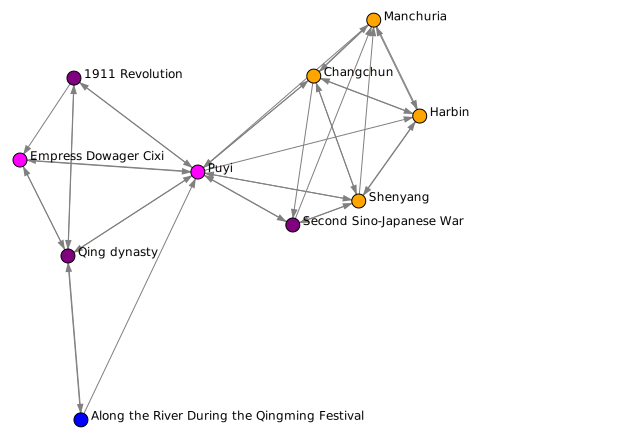

In [2651]:
idx = 0

mask_cc = labels_cc_summarized == idx
subgraph = summarized_adjacency[mask, :][:, mask][mask_cc, :][:, mask_cc].astype(bool)
print(names[mask][mask_cc])
print(set(sorted_names_col[summarized_biadjacency[mask, :][mask_cc].indices]))
SVG(svg_graph(subgraph + sparse.identity(subgraph.shape[0]), names=names[mask][mask_cc], 
              labels=labels[mask][mask_cc], width=400, height=400))

In [2652]:
core = CoreDecomposition()
core_labels = core.fit_transform(subgraph)
print(core_labels)
len(core_labels[core_labels == 3]) / subgraph.shape[0]

[2 2 3 2 3 3 3 2 3 3]


0.6

## RQ3: How explainable are our patterns?

Load patterns found with parameters $s=\beta=5$ on $\texttt{wikischools}$ dataset.

In [1244]:
dataset = 'wikischools'
s = 5
beta = 5
sorted_attributes = True

# Load result
with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
    result = pickle.load(data)
    
print(len(result))

2914


In [1245]:
# Load and preprocess data
graph = load_netset(dataset)
adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
if order_attributes:
    sort_index = np.argsort(freq_attribute)
else:
    sort_index = np.arange(0, len(freq_attribute))
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

Parsing files...
Done.


In [1246]:
# Summarized graph
summarized_adjacency = get_summarized_graph(adjacency, result)
summarized_adjacency

# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
print(len(mask))

561


**Connected components in summarized graph**

In [1247]:
labels_cc_summarized = get_connected_components(summarized_adjacency)
len(np.unique(labels_cc_summarized))

3877

In [1267]:
len(np.unique(get_connected_components(summarized_adjacency[mask, :][:, mask])))

73

In [1248]:
{i: n for i, n in enumerate(names) if 'Nicaea' in n}

{884: 'First Council of Nicaea'}

In [311]:
for c in result[1:]:
    if 884 in c[0]:
        print(c[0], c[1])

[294, 364, 548, 884, 998, 3027] [1812, 4041, 8453, 8561, 8740]
[294, 364, 548, 884, 3027] [1812, 4041, 8453, 8561, 8572, 8740]


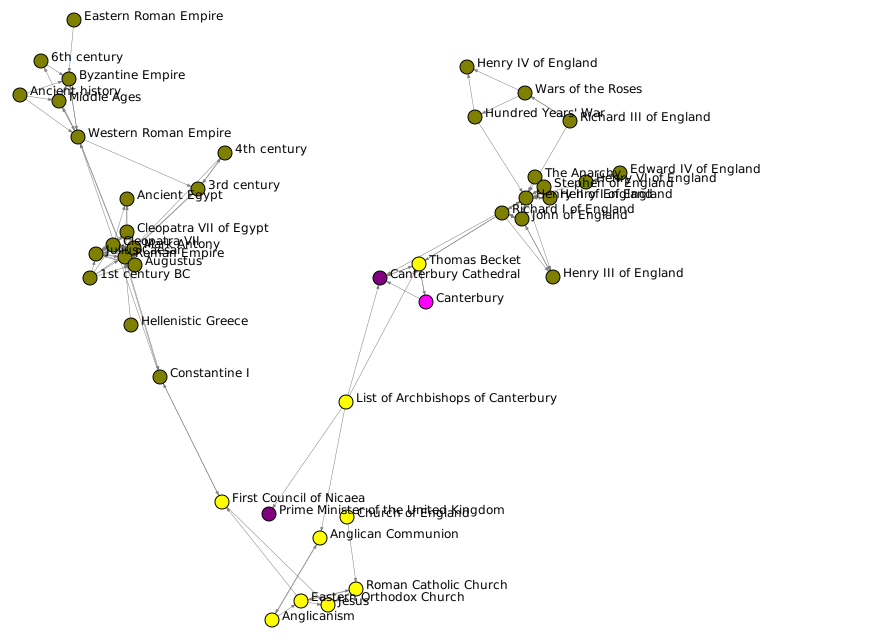

In [1249]:
# Find random connected component
sorted(Counter(labels_cc_summarized).items(), key=lambda x: x[1], reverse=True)[0]

# Plot connected components
mask_cc = labels_cc_summarized == 101
g = summarized_adjacency#[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]
SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=600, height=600, labels=labels[mask_cc]))

In [1252]:
g_cc

<43x43 sparse matrix of type '<class 'numpy.float64'>'
	with 112 stored elements in Compressed Sparse Row format>

In [1250]:
found_concepts = []
nodes = np.flatnonzero(mask_cc)
for c in result:
    if len(c[1]) > 0:
        for x in c[0]:
            if x in nodes:
                found_concepts.append(c)
                break

In [1251]:
print(f'Number of patterns related to pattern summary: {len(found_concepts)}')

Number of patterns related to pattern summary: 84


In [343]:
# Print related concepts
random_idxs = np.random.choice(len(found_concepts), 75)
for c in np.array(found_concepts, dtype=object)[random_idxs]:
    if "Prime Minister of the United Kingdom" in names[c[0]]:
        print(f'{(str(names[c[0]]))} - {(str(sorted_names_col[c[1]]))}')
        print()

['Anglicanism' 'Eastern Orthodox Church'
 'Prime Minister of the United Kingdom' 'Anglican Communion'
 'List of Archbishops of Canterbury'] - ['pare' 'primu' 'inter' 'equal' 'among']



In [1261]:
avg_attribute_size = np.mean([len(c[1]) for c in found_concepts])
print(f'Average length of pattern attributes: {avg_attribute_size}')

Average length of pattern attributes: 10.321428571428571


**Louvain**

In [1273]:
filename = f'result_wikischools_5_5_orderTrue'
result = load_result(outpath, filename)

# Load and preprocess data
graph = load_netset('wikischools')
adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels
orig_words = words.copy()

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= 5))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

louvain = Louvain(resolution=4.42)
labels_louvain = louvain.fit_transform(adjacency)

Parsing files...
Done.


In [1274]:
len(np.unique(labels_louvain))

73

In [1275]:
# Find Louvain community that share most of the nodes in previously found concept
canterbury_nodes = np.flatnonzero(mask_cc)
sizes_intersection = []

for i in range(73):
    louvain_mask = labels_louvain == i
    nodes_louvain_idx = np.flatnonzero(louvain_mask)
    sizes_intersection.append(len(set(nodes_louvain_idx).intersection(set(canterbury_nodes))))


In [1276]:
print(f'max intersection: {max(sizes_intersection)}')

max intersection: 21


Number of attributes:  3979
Number of nodes: 191


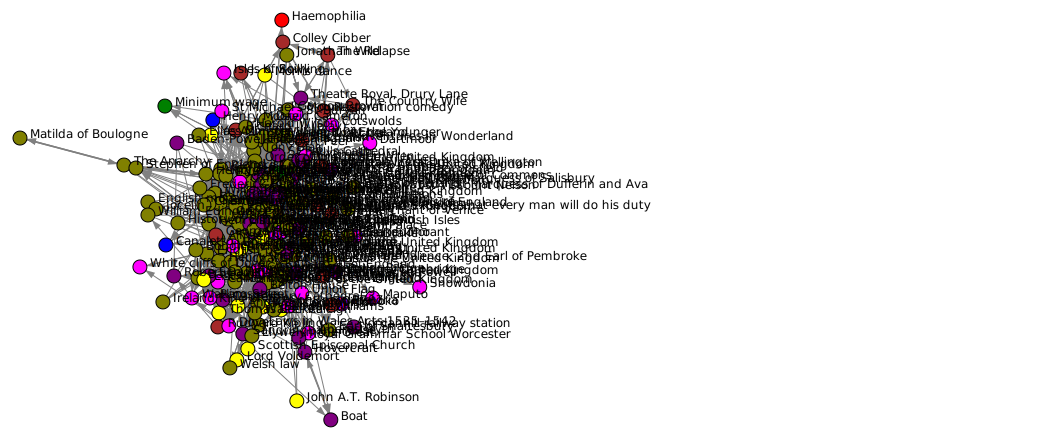

In [1277]:
louvain_mask = labels_louvain == np.argmax(sizes_intersection)

print('Number of attributes: ', len(np.unique(biadjacency[louvain_mask, :].indices)))
print(f'Number of nodes: {adjacency[louvain_mask, :][:, louvain_mask].shape[0]}')
image = svg_graph(adjacency[louvain_mask, :][:, louvain_mask], labels=labels[louvain_mask], 
              width=400, height=400, names=names[louvain_mask])    
SVG(image)

In [1268]:
# Find Louvain community that share most of the nodes in previously found concept
canterbury_nodes = np.flatnonzero(mask_cc)

nb_nodes_louvain = 0
for i in range(73):
    louvain_mask = labels_louvain == i
    nodes_louvain_idx = np.flatnonzero(louvain_mask)
    nb_nodes_louvain += len(nodes_louvain_idx)
    
print(f'Avg length of Louvain attributes: {nb_nodes_louvain/73}')

Avg length of Louvain attributes: 60.31506849315068


## RQ3-bis: find all patterns from a specific node category  

We can consider that a pattern belongs to a node category if the majority of its nodes are labelled identically as the category. 

**Wikivitals**

In [1354]:
dataset = 'wikivitals'
filename = f'result_{dataset}_5_5_orderTrue'
result = load_result(outpath, filename)

# Load and preprocess data
graph = load_netset(dataset)
adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels
orig_words = words.copy()

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= 5))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

if True:
    sort_index = np.argsort(freq_attribute)
else:
    sort_index = np.arange(0, len(freq_attribute))
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

# Graph summarization
# ------------------------------------------------------------------
summarized_adjacency = get_summarized_graph(adjacency, result)

# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))

# Summarized biadjacency
summarized_biadjacency = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
for c in result:
    if len(c[1]) > 0:
        for node in c[0]:
            summarized_biadjacency[node, c[1]] += 1
summarized_biadjacency = sparse.csr_matrix(summarized_biadjacency.astype(bool), shape=summarized_biadjacency.shape)

# Number of connected components NOT considering isolated nodes
labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
nb_cc = len(np.unique(labels_cc_summarized)) 

Parsing files...
Done.


In [1355]:
len(result)

1116

- Analysis of the number of patterns by node category
- comparison of the distribution of the patterns by category with the initial distribution of nodes by category. 

We see that our method has the tendency to detect more elemnts in specific categories, e.g People or Geography.

In [1343]:
label2patternsidx = defaultdict(list)

for i, p in enumerate(result):
    if len(p[1]) > 0:
        idx_most_common_cat = Counter(labels[p[0]]).most_common(1)[0][0]
        label2patternsidx[idx_most_common_cat].append(i)        

In [1344]:
# Number of patterns in each category (with corresponding weight in total)
for k, v in label2patternsidx.items():
    print(f'{names_labels[k]}: {len(v)} ({100*len(v)/len(result):.2f}%)')

Physical sciences: 77 (6.90%)
History: 71 (6.36%)
Philosophy and religion: 8 (0.72%)
Geography: 245 (21.95%)
People: 403 (36.11%)
Biological and health sciences: 53 (4.75%)
Everyday life: 6 (0.54%)
Society and social sciences: 189 (16.94%)
Arts: 8 (0.72%)
Technology: 47 (4.21%)
Mathematics: 8 (0.72%)


In [1337]:
for i, j in zip(names_labels, np.unique(labels, return_counts=True)[1] / len(labels)):
    print(f'{i}: {(100*j):.2f}%')

Arts: 6.72%
Biological and health sciences: 14.77%
Everyday life: 4.78%
Geography: 12.00%
History: 6.79%
Mathematics: 3.00%
People: 19.89%
Philosophy and religion: 4.35%
Physical sciences: 10.96%
Society and social sciences: 9.29%
Technology: 7.45%


We do the same analysis but with the summarized patterns.

In [1340]:
len(np.unique(labels_cc_summarized))

101

In [1362]:
label2sumpatternsidx = defaultdict(list)       
        
for i in range(len(np.unique(labels_cc_summarized))):
    mask_cc = labels_cc_summarized == i
    g = summarized_adjacency[mask, :][:, mask]
    g_cc = g[mask_cc, :][:, mask_cc]
    
    idx_most_common_cat = Counter(labels[mask][mask_cc]).most_common(1)[0][0]
    label2sumpatternsidx[idx_most_common_cat].append(i)

In [1369]:
label2sumpatternsidx_len = {k: len(v) for k, v in label2sumpatternsidx.items()}

In [1372]:
# Number of pattern summaries in each category (with corresponding weight in total)
for k, v in dict(sorted(label2sumpatternsidx_len.items(), key=lambda x: x[1], reverse=True)).items():
    print(f'{names_labels[k]}: {(v)} ({100*(v)/len(np.unique(labels_cc_summarized)):.2f}%)')

People: 26 (25.74%)
Geography: 21 (20.79%)
History: 14 (13.86%)
Physical sciences: 13 (12.87%)
Biological and health sciences: 10 (9.90%)
Society and social sciences: 6 (5.94%)
Philosophy and religion: 5 (4.95%)
Mathematics: 2 (1.98%)
Arts: 2 (1.98%)
Technology: 2 (1.98%)


## RQ3-bis: find disconnected patterns, i.e indeed unexpected

In [138]:
dataset = 'wikivitals'
filename = f'result_{dataset}_5_5_orderTrue'
outpath = f'../output/result'
result = load_result(outpath, filename)

# Load and preprocess data
graph = load_netset(dataset)
adjacency = graph.adjacency
biadjacency = graph.biadjacency
orig_biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels
orig_words = words.copy()

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= 5))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

if True:
    sort_index = np.argsort(freq_attribute)
else:
    sort_index = np.arange(0, len(freq_attribute))
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

Parsing files...
Done.


In [139]:
print(len(result))

1116


 This is an example of disconnected pattern. It is unexpected to see a dense structure with a single node not connected yet sharing similar attributes.

[939]
[1664, 2241, 3449, 3855, 4194, 5619, 5811, 6240, 7917, 8169, 8893, 9116, 9167] [9383, 12458, 16188, 17038, 18177]
['Centres' 'Financial' 'Global' 'Index' 'rank']


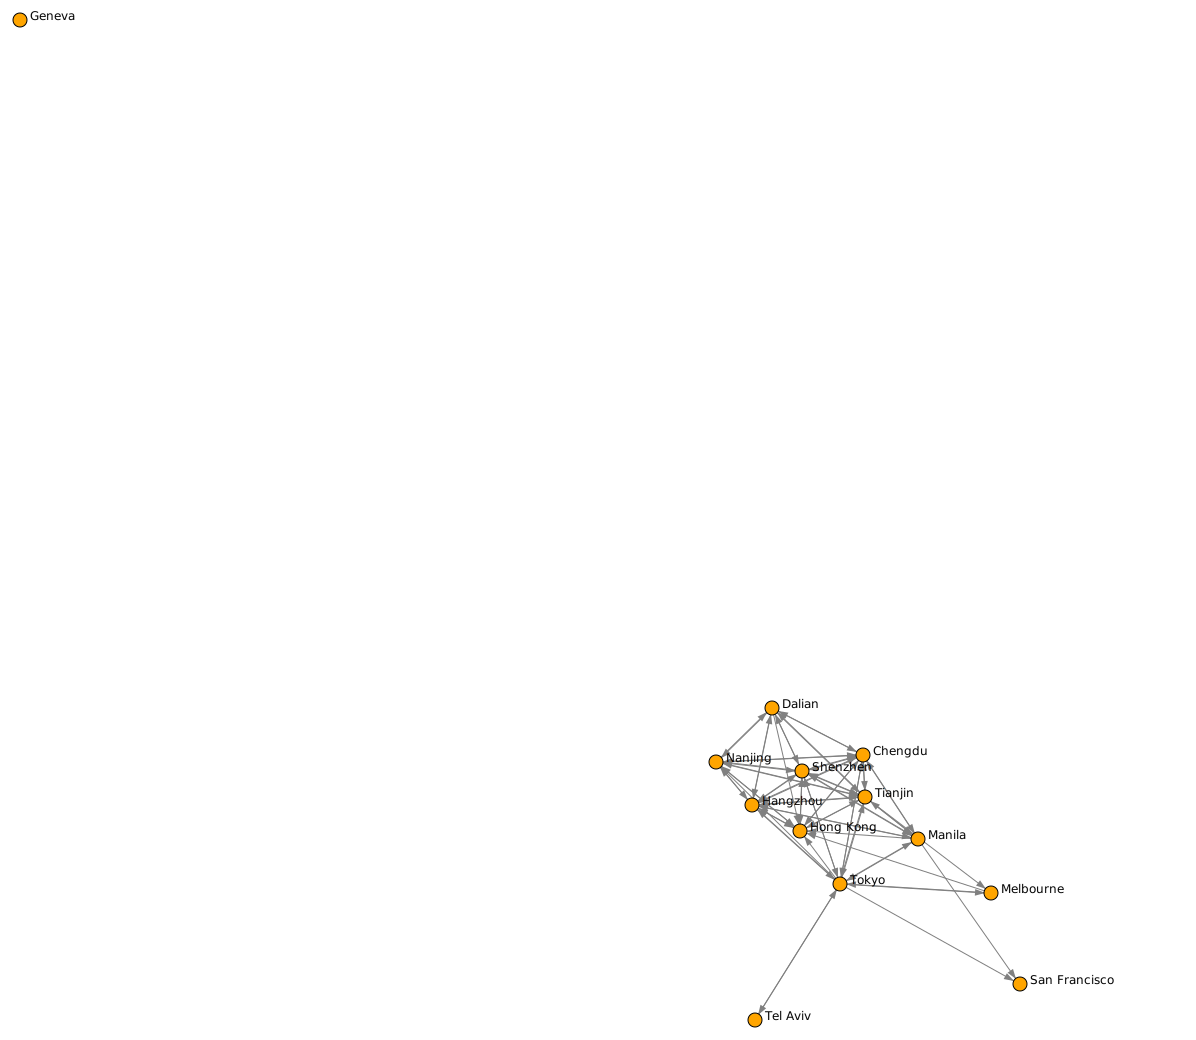

In [74]:
rand_idx = [939] #np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(rand_idx)
print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))

image = svg_graph(image_adj, names=names[objs], labels=labels[objs], width=1000, height=1000)

# Save data
gcc_coo = image_adj.tocoo()
with open('wikivitals_finance_capitals_pattern.txt', 'w') as f:
    for x, y in zip(gcc_coo.row, gcc_coo.col):
        f.write(f'{x},{y}\n')
with open('wikivitals_finance_capitals_categories.txt', 'w') as f:
    for idx, (y, z) in enumerate(zip(names_labels[labels[objs]], names[objs])):
        f.write(f'{idx},{y},{z}\n')
    
SVG(image)

In [1403]:
# Words in Geneva node
orig_words[orig_biadjacency[3449].indices]

array(['power', 'city', 'ninth', 'from', 'metropolis', 'exit', 'by',
       'spread', 'populous', 'most', 'concern', 'for', 'Vevey', 'be',
       'Centres', 'UN', 'resident', 'listen', 'east', 'compact',
       'Romansh', 'which', 'international', 'competitiveness', 'Red',
       'ville', 'its', 'numerous', 'instance', 'liveable', 'country',
       'the', 'Peace', 'combatant', 'Métropole', 'both', 'a', 'və',
       'situate', 'many', 'Capital', 'Zürich', 'German', 'Geneva', 'part',
       'Riviera', 'organization', 'Vaud', 'Basel', 'Romandy', 'Arpitan',
       'Rhône', 'ten', 'Cross', 'in', 'Index', 'this', 'Bains', 'French',
       'worldwide', 'to', 'second', 'prisoner', 'fourth', 'inner',
       'centre', 'Bank', 'wartime', 'essentially', 'north', 'among',
       'important', 'ee', 'Financial', 'financial', 'suburb', 'presence',
       'purchasing', 'and', 'Republic', 'Lake', 'where', 'inhabitant',
       'behind', 'New', 'le', 'gross', 'City', 'world', 'de', 'Nations',
       'with

In [1407]:
names_cities = names[[1664, 3449, 3855, 4194, 5811, 6240, 8169, 9116, 9167]]
names_cities

array(['Chengdu', 'Geneva', 'Hangzhou', 'Hong Kong', 'Melbourne',
       'Nanjing', 'Shenzhen', 'Tianjin', 'Tokyo'], dtype='<U62')

In [1408]:
# Verify if name of cities are in neighbors for Geneva nodes
for n in names_cities:
    print(f'{n}: {n in names[get_neighbors(adjacency, node=3449)]}')

Chengdu: False
Geneva: False
Hangzhou: False
Hong Kong: False
Melbourne: False
Nanjing: False
Shenzhen: False
Tianjin: False
Tokyo: False


Another example in the filed of music, with the nodes `Tupac Shakur` (Rap singer) and `Kind of Blue` (Jazz album) being disconnected from the cluster, despite the fact that its sharing a lot of similar characteristics. In that sense, this subgraph is unexpected.

[291]
[893, 2768, 5010, 5245, 9105, 9310] [4346, 10925, 14790, 15721, 17668, 17847, 18035, 18247]
['RIAA' 'certify' 'Records' 'album' 'sell' 'release' 'music' 'record']


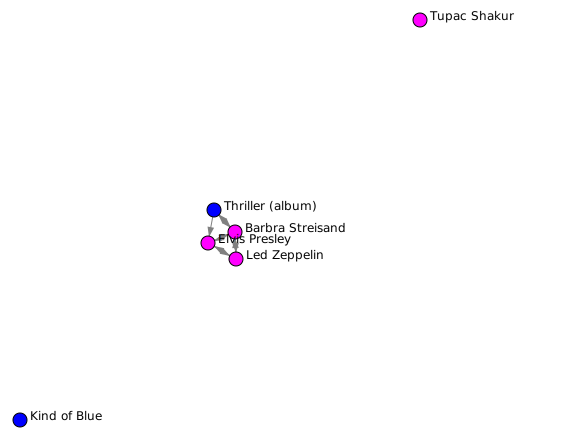

In [75]:
rand_idx = [291] #np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(rand_idx)
print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))

image = svg_graph(image_adj, names=names[objs], labels=labels[objs], width=400, height=400)

with open('img/music_wikivitals.svg','wb+') as outfile:
    outfile.write(SVG(image).data.encode('utf-8'))
    
SVG(image)

Another example about solar system field

[105]
[701, 6305, 6320, 7083, 7085] [2297, 16022, 17201, 17306, 17368, 18157]
['planetesimal' 'Solar' 'System' 'Sun' 'planet' 'Earth']


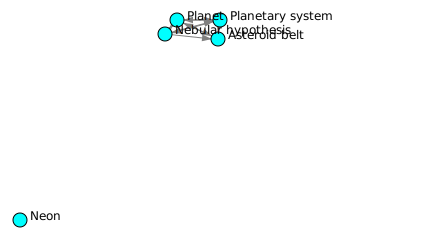

In [76]:
rand_idx = [105] #np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(rand_idx)
print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))

image = svg_graph(image_adj, names=names[objs], labels=labels[objs], width=200, height=200)
SVG(image)

Example about kings in Europe where the King of England is not connected to its relatives in France.

[113]
[3975, 4077, 4823, 5023, 5432] [2459, 17874, 17975, 17986, 18114, 18187, 18305]
['capetian' 'king' 'King' 'dynasty' 'France' 'french' 'war']


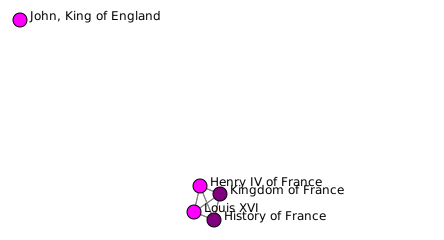

In [77]:
rand_idx = [113] #np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(rand_idx)
print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))

image = svg_graph(image_adj, names=names[objs], labels=labels[objs], width=200, height=200)
SVG(image)

Stranger pattern

[576]
[2511, 2783, 4474, 5447, 5699, 6622, 8214, 9014, 9169] [6363, 14403, 16797, 17631, 18179]
['primetime' 'Emmy' 'Awards' 'television' 'receive']


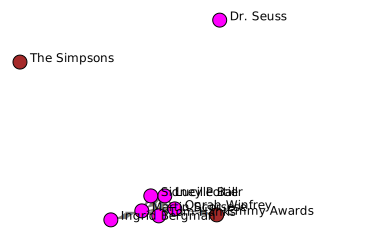

In [78]:
rand_idx = [576] #np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(rand_idx)
print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))

image = svg_graph(image_adj, names=names[objs], labels=labels[objs], width=200, height=200)
SVG(image)

[711]
[1350, 1903, 8542, 9388, 9389, 9390, 9393, 9895] [7808, 12395, 12572, 12684, 13981, 14875, 14924, 17287, 17442, 17450, 18158]
['Medalists' 'undergraduate' 'Fields' 'alumnus' 'campus' 'laureate'
 'faculty' 'student' 'university' 'Nobel' 'research']


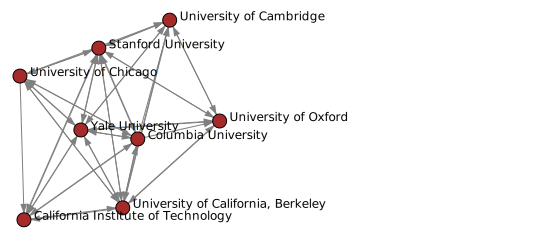

In [79]:
rand_idx = [711] #np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(rand_idx)
print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))

image = svg_graph(image_adj, names=names[objs], labels=labels[objs], width=200, height=200)
SVG(image)

[213]
[1166, 1795, 1983, 4153, 8430, 9610] [3619, 11381, 15617, 17723, 18149, 18234]
['Crow' 'Jim' 'racial' 'african' 'southern' 'law']


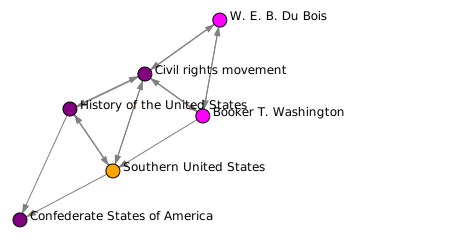

In [80]:
rand_idx = [213] #np.random.choice(len(result), 1)
concept = result[rand_idx[0]]
objs, attrs = concept

print(rand_idx)
print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))

# Save data
gcc_coo = image_adj.tocoo()
with open('wikivitals_civil_rights_pattern.txt', 'w') as f:
    for x, y in zip(gcc_coo.row, gcc_coo.col):
        f.write(f'{x},{y}\n')
with open('wikivitals_civil_rights_categories.txt', 'w') as f:
    for idx, (y, z) in enumerate(zip(names_labels[labels[objs]], names[objs])):
        f.write(f'{idx},{y},{z}\n')
        
image = svg_graph(image_adj, names=names[objs], labels=labels[objs], width=200, height=200)
SVG(image)

Why the node 'Martin Luther King Jr.' is not in the Civil Rights movement pattern above? $\rightarrow$ we try to verify if this node is in any pattern.

In [83]:
# Index of Martin Luther King Jr. node
{i: n for i, n in enumerate(names) if 'Martin' in n}

{5696: 'Martin Heidegger',
 5697: 'Martin Luther',
 5698: 'Martin Luther King Jr.',
 5699: 'Martin Scorsese',
 5700: 'Martina Navratilova',
 5701: 'Martinique'}

In [85]:
# Martin Luther King Jr. is not in any pattern, except the seed pattern
for p in result:
    if 5698 in p[0]:
        print(p)

(array([    0,     1,     2, ..., 10008, 10009, 10010]), [])


In [91]:
for word in ['Crow', 'Jim', 'racial', 'african', 'southern', 'law']:
    if word in orig_words[orig_biadjacency[5698].indices]:
        print(word)

racial


**What is the closest pattern summary?**

In [94]:
# Summarized graph
summarized_adjacency = get_summarized_graph(adjacency, result)
summarized_adjacency

# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
print(len(mask))

labels_cc_summarized = get_connected_components(summarized_adjacency)
len(np.unique(labels_cc_summarized))

808


9295

In [96]:
# Index of Confederate node
{i: n for i, n in enumerate(names) if 'Confederate States' in n}

{1983: 'Confederate States of America'}

In [101]:
# Pattern summary index for the node
print(labels_cc_summarized[1983])

51


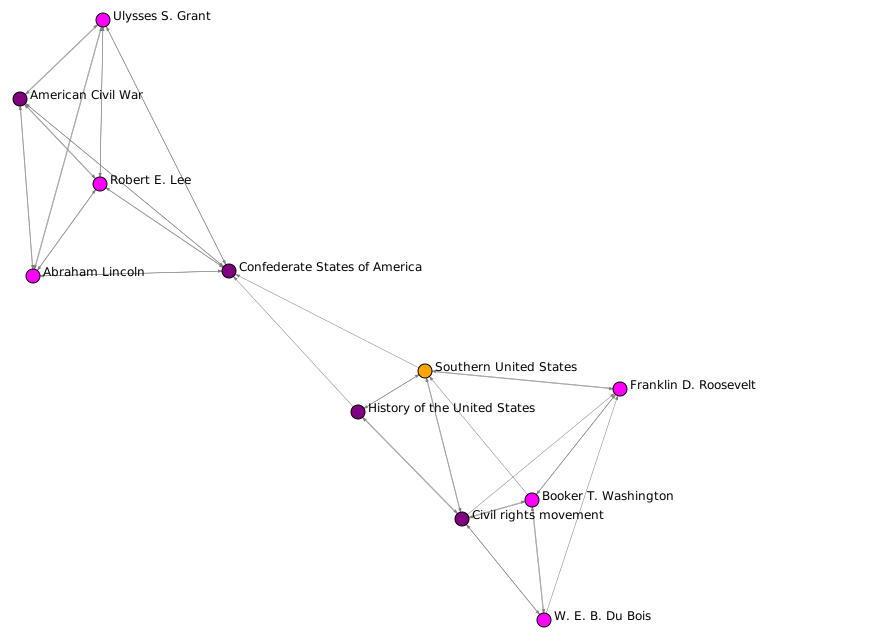

In [104]:
# Find corresponding connected component
mask_cc = labels_cc_summarized == 51
g = summarized_adjacency#[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]
SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=600, height=600, labels=labels[mask_cc]))

**Iterates over patterns**

In [1440]:
indexes = set(np.arange(0, len(result)))

[526] 1
[784, 6337, 6888, 6945, 7235, 7366, 7371, 8662, 8663] [6274, 6764, 7271, 7630, 10010, 17048]
['Diagnostic' 'Disorders' 'Mental' 'Manual' 'Statistical' 'disorder']


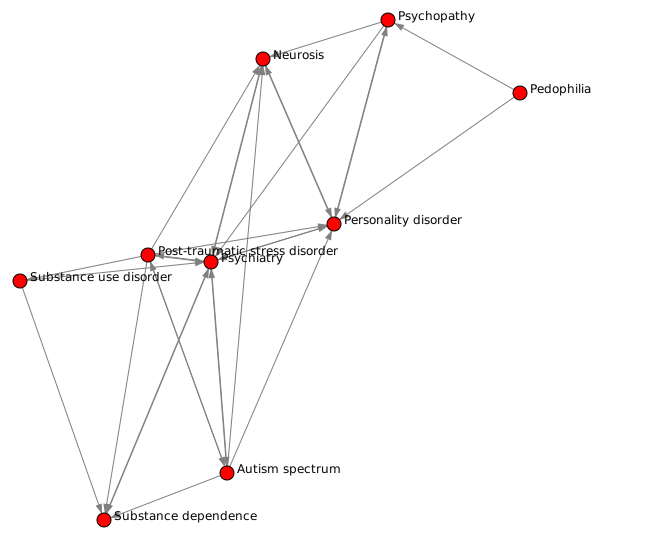

In [3031]:
rand_idx = np.random.choice(list(indexes), 1)

concept = result[rand_idx[0]]
objs, attrs = concept
indexes.remove(rand_idx[0])

print(rand_idx, len(indexes))
print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))

image = svg_graph(image_adj, names=names[objs], labels=labels[objs], width=500, height=500)
SVG(image)

## Additional experiment - impact of U constraint on quantitative and qualitative measures  

We run our algorithm without any constraint on Unexpectedness.  
We already compared the number of patterns found without the constraint with a run with the constraint. We now focus on additional measures:  
* Cover rate without U 
* qualitative analysis of pattern summaries without U $\rightarrow$ Do we find more interesting pattern withtout U? Can we quantify the information missed when using U constraint?

In [328]:
# Load result
dataset = 'wikischools'
beta = 5
s = 5
sorted_attributes = True

with open(f"../result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}_without_constraint.bin", "rb") as data:
    result = pickle.load(data)

# Load and preprocess data
graph = load_netset(dataset)
adjacency = graph.adjacency
biadjacency = graph.biadjacency
orig_biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels
orig_words = words.copy()

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= 5))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

if True:
    sort_index = np.argsort(freq_attribute)
else:
    sort_index = np.arange(0, len(freq_attribute))
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

Parsing files...
Done.


In [330]:
print(f'Number of patterns without U constraint: {len(result)}')

Number of patterns without U constraint: 3828


In [331]:
# Most interesting patterns whithout pruning constraint on U in the algorithm
most_u_patterns = sorted(result, key=lambda x: x[2], reverse=True)

In [ ]:
orig_biadjacency[]

266
['ftse' 'plc' 'stock' 'index' 'exchang' 'york' 'london' 'list' 'compani'
 'british' 'largest' 'new']
Unexpectedness: 38.43320458949394
[1222, 2239, 2489, 3476, 3818]


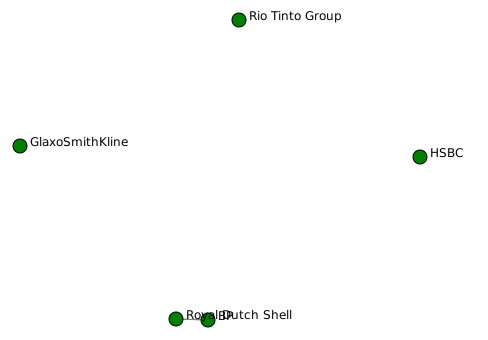

In [486]:
idx = 266 #np.random.choice(len(result))
print(idx)
nodes_idx = result[idx][0]
attrs_idx = result[idx][1]
print(sorted_names_col[attrs_idx])
print(f'Unexpectedness: {result[idx][2]}')
print(nodes_idx)
SVG(svg_graph(adjacency[nodes_idx, :][:, nodes_idx] + sparse.identity(adjacency[nodes_idx, :][:, nodes_idx].shape[0]), names=names[nodes_idx], labels=labels[nodes_idx]))

['transactinid' 'homologu' 'behav' 'heavier' 'synthet' 'radioact'
 'laboratori' 'isotop' 'tabl' 'stabl' 'atom' 'metal' 'properti' 'symbol'
 'chemic' 'element' 'member' 'group' 'period' 'number']
Unexpectedness: 60.53736366993745


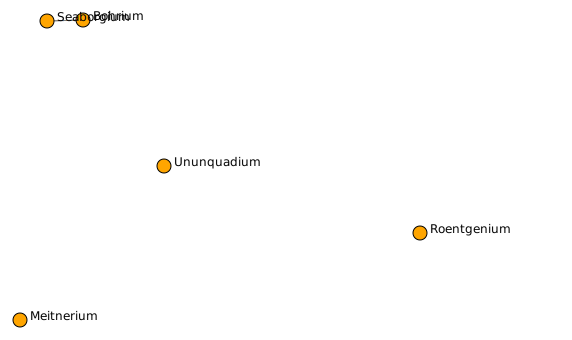

In [337]:
idx = 1
nodes_idx = most_u_patterns[idx][0]
attrs_idx = most_u_patterns[idx][1]
print(sorted_names_col[attrs_idx])
print(f'Unexpectedness: {most_u_patterns[idx][2]}')
SVG(svg_graph(adjacency[nodes_idx, :][:, nodes_idx], names=names[nodes_idx], labels=labels[nodes_idx]))

['silveri' 'atom' 'metal' 'symbol' 'element' 'consid' 'number']
Unexpectedness: -57.00047913797464


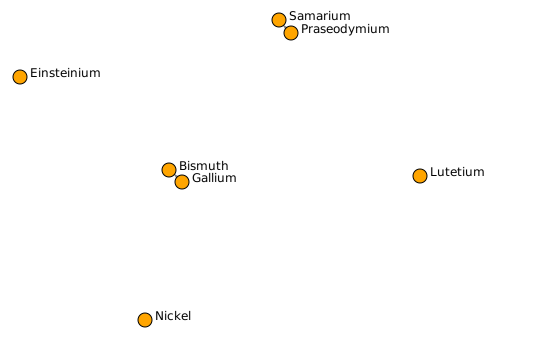

In [339]:
idx = -25
nodes_idx = most_u_patterns[idx][0]
attrs_idx = most_u_patterns[idx][1]
print(sorted_names_col[attrs_idx])
print(f'Unexpectedness: {most_u_patterns[idx][2]}')
SVG(svg_graph(adjacency[nodes_idx, :][:, nodes_idx], names=names[nodes_idx], labels=labels[nodes_idx]))

**Summarized graph without U constraint**

In [501]:
# Summarized graph
summarized_adjacency = get_summarized_graph(adjacency, result)
summarized_adjacency

# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
print(len(mask))

labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
len(np.unique(labels_cc_summarized))

561


73

40


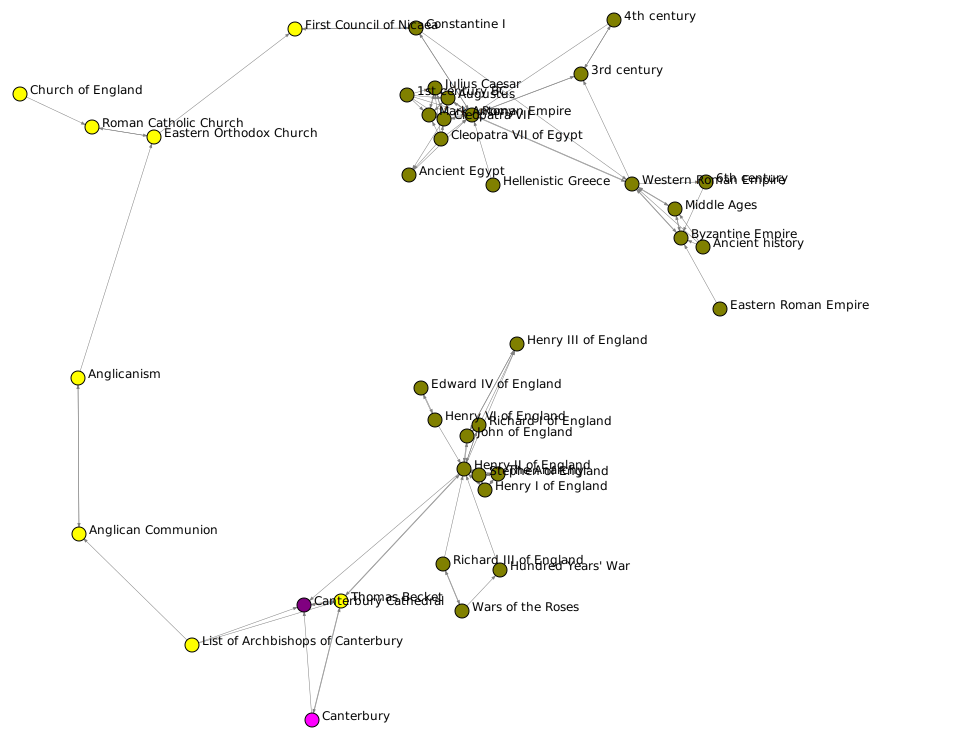

In [355]:
# Find corresponding connected component
mask_cc = labels_cc_summarized == 9
g = summarized_adjacency[mask, :][:, mask]
g_cc = g[mask_cc, :][:, mask_cc]
SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask][mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=700, height=700, labels=labels[mask][mask_cc]))

## Annexes
---

Look for resolutions for Louvain algorithm, according to number of patterns needed to be found.

In [1110]:
# Looking for resolutions
dataset = 'wikischools'
graph = load_netset(dataset)
filename = f'result_{dataset}_5_5_orderTrue'

with open(f"../output/result/{filename}.bin", "rb") as data:
    myres = pickle.load(data)
sumadj = get_summarized_graph(graph.adjacency, myres)
mask = np.flatnonzero(sumadj.dot(np.ones(sumadj.shape[1])))
labels_cc_summarized = get_connected_components(sumadj[mask, :][:, mask])
print(len(np.unique(labels_cc_summarized)))

labels_pred = Louvain(2.8).fit_transform(graph.adjacency)
print(len(np.unique(labels_pred)))

Parsing files...
Done.
73
41


### RQ2 annexes

In [781]:
%%time

def build_concept_attributes(result, biadjacency, summarized_biadjacency, mask, nb_cc, 
                             labels_cc_summarized, labels_louvain, kmeans_gnn_labels, kmeans_spectral_labels,
                            kmeans_doc2vec_labels):

    # Unexpectedness algorithm 
    concept_attributes = np.zeros((len(result), biadjacency.shape[1]))
    for i, c in enumerate(result[1:]):
        concept_attributes[i, c[1]] = 1
    
    # Unexpectedness algorithm + summarized patterns
    nb_cc = len(np.unique(labels_cc_summarized))
    concept_summarized_attributes = np.zeros((nb_cc, biadjacency.shape[1]))
    for c in range(nb_cc):
        mask_cc = labels_cc_summarized == c
        indices_attr = summarized_biadjacency[mask][mask_cc].indices
        for ind in indices_attr:
            concept_summarized_attributes[c, ind] += 1
        
    # Louvain Algorithm
    nb_cc = len(np.unique(labels_louvain))
    concept_louvain_attributes = np.zeros((nb_cc, biadjacency.shape[1]))
    for c in range(nb_cc):
        mask_cc = labels_louvain == c
        indices_attr = biadjacency[mask_cc].indices
        for ind in indices_attr:
            concept_louvain_attributes[c, ind] += 1
        
    # GNN + KMeans Algorithm
    nb_cc = len(np.unique(kmeans_gnn_labels))
    concept_gnn_kmeans_attributes = np.zeros((nb_cc, biadjacency.shape[1]))
    for c in range(nb_cc):
        mask_cc = kmeans_gnn_labels == c
        indices_attr = biadjacency[mask_cc].indices
        for ind in indices_attr:
            concept_gnn_kmeans_attributes[c, ind] += 1
        
    # Spectral + KMeans Algorithm
    nb_cc = len(np.unique(kmeans_spectral_labels))
    concept_spectral_kmeans_attributes = np.zeros((nb_cc, biadjacency.shape[1]))
    for c in range(nb_cc):
        mask_cc = kmeans_spectral_labels == c
        indices_attr = biadjacency[mask_cc].indices
        for ind in indices_attr:
            concept_spectral_kmeans_attributes[c, ind] += 1
        
    # Doc2Vec + KMeans Algorithm
    nb_cc = len(np.unique(kmeans_doc2vec_labels))
    concept_doc2vec_kmeans_attributes = np.zeros((nb_cc, biadjacency.shape[1]))
    for c in range(nb_cc):
        mask_cc = kmeans_doc2vec_labels == c
        indices_attr = biadjacency[mask_cc].indices
        for ind in indices_attr:
            concept_doc2vec_kmeans_attributes[c, ind] += 1

    return concept_attributes, concept_summarized_attributes, concept_louvain_attributes, concept_gnn_kmeans_attributes, concept_spectral_kmeans_attributes, concept_doc2vec_kmeans_attributes


CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 12.9 µs


In [782]:
resolutions = {'wikivitals-fr': {27: 1.89}, 'wikivitals': {65: 4.70}, 'wikischools': {58: 3.7}}

In [ ]:
%%time

datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
sorted_attributes = True
ss = [5]
betas = [8, 7, 6, 5]
k = 25 # Spectral embedding dimension
avgs = defaultdict(dict)

for dataset in datasets:
    avgs[dataset] = defaultdict(dict)
    for b in betas:
        avgs[dataset][b] = defaultdict(dict)
        for s in ss:
            avgs[dataset][b][s] = defaultdict(list)
            
            # Load result
            with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
                result = pickle.load(data)
            #print(len(result))

            # Load and preprocess data
            graph = load_netset(dataset)
            adjacency = graph.adjacency
            biadjacency = graph.biadjacency
            names = graph.names
            words = graph.names_col
            labels = graph.labels
            names_labels = graph.names_labels
            orig_words = words.copy()
            
            # Degree of attribute = # articles in which it appears
            freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
            index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

            # Filter data with index
            biadjacency = biadjacency[:, index]
            words = words[index]
            freq_attribute = freq_attribute[index]

            # Order attributes according to their ascending degree
            # This allows to add first attributes that will generate bigger subgraphs
            if order_attributes:
                sort_index = np.argsort(freq_attribute)
            else:
                sort_index = np.arange(0, len(freq_attribute))
            sorted_degs = freq_attribute[sort_index]
            filt_biadjacency = biadjacency[:, sort_index]
            sorted_names_col = words[sort_index]

            # Summarized graph
            summarized_adjacency = get_summarized_graph(adjacency, result)
            summarized_adjacency

            # Summarized graph filtered on used nodes
            mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))

            summarized_biadjacency = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
            for c in result:
                if len(c[1]) > 0:
                    for node in c[0]:
                        summarized_biadjacency[node, c[1]] += 1

            summarized_biadjacency = sparse.csr_matrix(summarized_biadjacency.astype(bool), shape=summarized_biadjacency.shape)
            
            # Number of connected components NOT considering isolated nodes
            labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
            nb_cc = len(np.unique(labels_cc_summarized)) 

            louvain = Louvain(resolution=resolutions.get(dataset).get(nb_cc)) 
            labels_louvain = louvain.fit_transform(adjacency)
            nb_louvain = len(np.unique(labels_louvain))

            features = biadjacency

            hidden_dim = 16
            n_labels = len(np.unique(labels))

            # GNN classifier 
            gnn = GNNClassifier(dims=[hidden_dim, n_labels],
                                layer_types='conv',
                                activations=['Relu', 'Softmax'],
                                verbose=False)

            gnn.fit(adjacency, features, labels, train_size=0.8, val_size=0.1, test_size=0.1, n_epochs=50)
            # KMeans on GNN node embedding
            gnn_embedding = gnn.layers[-1].embedding

            kmeans = KMeansDense(n_clusters=nb_cc) # k = number of connected components in summarized graph
            kmeans_gnn_labels = kmeans.fit_transform(gnn_embedding)

            kmeans = KMeans(n_clusters=nb_cc) # k = number of connected components in summarized graph
            kmeans_spectral_labels = kmeans.fit_transform(adjacency)
            
            # Doc2Vec model on whole biadjacency matrix
            corpus = list(MyCorpus(biadjacency, orig_words))
            model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=10, epochs=50)
            model.build_vocab(corpus)

            # Training model
            model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

            # KMeans model
            kmeans = KMeansDense(n_clusters=nb_cc) # k = number of connected components in summarized graph
            kmeans_doc2vec_labels = kmeans.fit_transform(model.dv.vectors)
            
            concept_attributes, concept_summarized_attributes, concept_louvain_attributes, concept_gnn_kmeans_attributes, concept_spectral_kmeans_attributes, concept_doc2vec_kmeans_attributes = build_concept_attributes(result, biadjacency, summarized_biadjacency, mask, nb_cc, 
                                     labels_cc_summarized, labels_louvain, kmeans_gnn_labels, kmeans_spectral_labels, kmeans_doc2vec_labels)
            
            wd_matrix = np.zeros((len(result), len(result)))
            wd_matrix_summarized = np.zeros((nb_cc, nb_cc))
            wd_matrix_louvain = np.zeros((nb_louvain, nb_louvain))
            wd_matrix_spectral_kmeans = np.zeros((nb_cc, nb_cc))
            wd_matrix_gnn_kmeans = np.zeros((nb_cc, nb_cc))
            wd_matrix_doc2vec_kmeans = np.zeros((nb_cc, nb_cc))
            
            # Unexpectedness algorithm + concepts
            spectral = Spectral(k)
            emb = spectral.fit_transform(normalize(concept_attributes, p=2))
            for i, c1 in enumerate(result[1:]):
                for j, c2 in enumerate(result[1:]):    
                    wd_matrix[i, j] = wasserstein_distance(emb[i], emb[j])
            avgs[dataset][b][s]['concepts'].append(np.mean(wd_matrix))
            
            # Louvain
            spectral = Spectral(k)
            emb_louvain = spectral.fit_transform(normalize(concept_louvain_attributes, p=2))
            for i in range(nb_louvain):
                for j in range(nb_louvain):    
                    wd_matrix_louvain[i, j] = wasserstein_distance(emb_louvain[i], emb_louvain[j])
            avgs[dataset][b][s]['louvain'].append(np.mean(wd_matrix_louvain))

            # Others
            spectral_summarized = Spectral(k)
            emb_summarized = spectral_summarized.fit_transform(normalize(concept_summarized_attributes, p=2))
            spectral_spectral_kmeans = Spectral(k)
            emb_spectral_kmeans = spectral_spectral_kmeans.fit_transform(normalize(concept_spectral_kmeans_attributes, p=2))
            spectral_gnn_kmeans = Spectral(k)
            emb_gnn_kmeans = spectral_gnn_kmeans.fit_transform(normalize(concept_gnn_kmeans_attributes, p=2))
            spectral_doc2vec_kmeans = Spectral(k)
            emb_doc2vec_kmeans = spectral_doc2vec_kmeans.fit_transform(normalize(concept_doc2vec_kmeans_attributes, p=2))
            
            print(emb.shape)
            print(emb_summarized.shape)
            print(emb_spectral_kmeans.shape)
            print(emb_gnn_kmeans.shape)
            print(emb_doc2vec_kmeans.shape)
            
            for i in range(nb_cc):
                for j in range(nb_cc):    
                    wd_matrix_summarized[i, j] = wasserstein_distance(emb_summarized[i], emb_summarized[j])
                    wd_matrix_spectral_kmeans[i, j] = wasserstein_distance(emb_spectral_kmeans[i], emb_spectral_kmeans[j])
                    wd_matrix_gnn_kmeans[i, j] = wasserstein_distance(emb_gnn_kmeans[i], emb_gnn_kmeans[j])
                    wd_matrix_doc2vec_kmeans[i, j] = wasserstein_distance(emb_doc2vec_kmeans[i], emb_doc2vec_kmeans[j])
            avgs[dataset][b][s]['summarized'].append(np.mean(wd_matrix_summarized))
            avgs[dataset][b][s]['spectral_kmeans'].append(np.mean(wd_matrix_spectral_kmeans))
            avgs[dataset][b][s]['gnn_kmeans'].append(np.mean(wd_matrix_gnn_kmeans))
            avgs[dataset][b][s]['doc2vec_kmeans'].append(np.mean(wd_matrix_doc2vec_kmeans))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


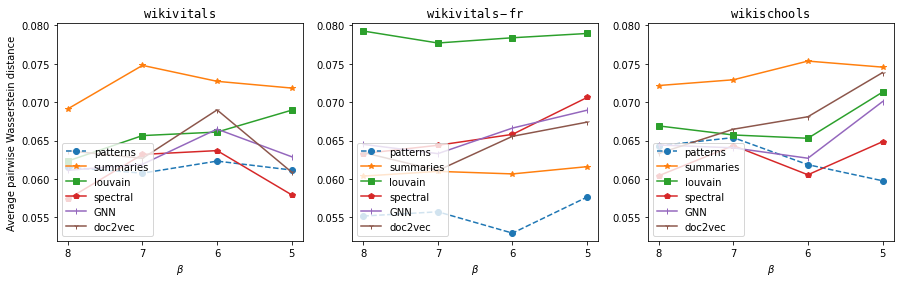

In [803]:
# k = 25, s = 5, concept_attributes matrices contains numerical data instead of binary
# with normalization before Spectral embedding
fig, ax = plt.subplots(1, len(datasets), figsize=(15, 4))
markers = ['o', '*', 's', 'p', '|', '1']
min_y = np.inf
max_y = 0

for d, dataset in enumerate(datasets):
    
    vals_concepts = [avgs.get(dataset).get(int(b)).get(5).get('concepts')[0] for b in betas]
    vals_summarized = [avgs.get(dataset).get(int(b)).get(5).get('summarized')[0] for b in betas]
    vals_louvain = [avgs.get(dataset).get(int(b)).get(5).get('louvain')[0] for b in betas]
    vals_spectral = [avgs.get(dataset).get(int(b)).get(5).get('spectral_kmeans')[0] for b in betas]
    vals_gnn = [avgs.get(dataset).get(int(b)).get(5).get('gnn_kmeans')[0] for b in betas]
    vals_doc2vec = [avgs.get(dataset).get(int(b)).get(5).get('doc2vec_kmeans')[0] for b in betas]
    
    min_y = min(min_y, min(np.min(vals_concepts), np.min(vals_summarized), np.min(vals_louvain), np.min(vals_spectral),
               np.min(vals_gnn), np.min(vals_doc2vec)))
    max_y = max(max_y, max(np.max(vals_concepts), np.max(vals_summarized), np.max(vals_louvain), np.max(vals_spectral),
               np.max(vals_gnn), np.max(vals_doc2vec)))
        
    ax[d].plot(vals_concepts, label='patterns', marker=markers[0], linestyle='dashed')
    ax[d].plot(vals_summarized, label='summaries', marker=markers[1])
    ax[d].plot(vals_louvain, label='louvain', marker=markers[2])
    ax[d].plot(vals_spectral, label='spectral', marker=markers[3])
    ax[d].plot(vals_gnn, label='GNN', marker=markers[4])
    ax[d].plot(vals_doc2vec, label='doc2vec', marker=markers[5])
    ax[d].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
    ax[d].set_title(rf'$\tt{dataset}$')
    ax[d].legend(loc='lower left')
    ax[d].set_xlabel(r'$\beta$')
    
for i in range(len(datasets)):
    ax[i].set_ylim(min_y - 0.001, max_y + 0.001)
    
ax[0].set_ylabel('Average pairwise Wasserstein distance');

plt.savefig('../output/img/wd_distances_concepts.eps', dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


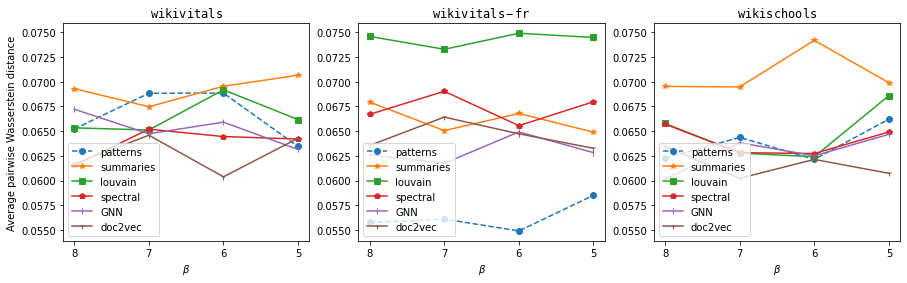

In [797]:
# k = 25, s = 5, concept_attributes matrices contains numerical data instead of binary
fig, ax = plt.subplots(1, len(datasets), figsize=(15, 4))
markers = ['o', '*', 's', 'p', '|', '1']
min_y = np.inf
max_y = 0

for d, dataset in enumerate(datasets):
    
    vals_concepts = [avgs.get(dataset).get(int(b)).get(5).get('concepts')[0] for b in betas]
    vals_summarized = [avgs.get(dataset).get(int(b)).get(5).get('summarized')[0] for b in betas]
    vals_louvain = [avgs.get(dataset).get(int(b)).get(5).get('louvain')[0] for b in betas]
    vals_spectral = [avgs.get(dataset).get(int(b)).get(5).get('spectral_kmeans')[0] for b in betas]
    vals_gnn = [avgs.get(dataset).get(int(b)).get(5).get('gnn_kmeans')[0] for b in betas]
    vals_doc2vec = [avgs.get(dataset).get(int(b)).get(5).get('doc2vec_kmeans')[0] for b in betas]
    
    min_y = min(min_y, min(np.min(vals_concepts), np.min(vals_summarized), np.min(vals_louvain), np.min(vals_spectral),
               np.min(vals_gnn), np.min(vals_doc2vec)))
    max_y = max(max_y, max(np.max(vals_concepts), np.max(vals_summarized), np.max(vals_louvain), np.max(vals_spectral),
               np.max(vals_gnn), np.max(vals_doc2vec)))
        
    ax[d].plot(vals_concepts, label='patterns', marker=markers[0], linestyle='dashed')
    ax[d].plot(vals_summarized, label='summaries', marker=markers[1])
    ax[d].plot(vals_louvain, label='louvain', marker=markers[2])
    ax[d].plot(vals_spectral, label='spectral', marker=markers[3])
    ax[d].plot(vals_gnn, label='GNN', marker=markers[4])
    ax[d].plot(vals_doc2vec, label='doc2vec', marker=markers[5])
    ax[d].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
    ax[d].set_title(rf'$\tt{dataset}$')
    ax[d].legend(loc='lower left')
    ax[d].set_xlabel(r'$\beta$')
    
for i in range(len(datasets)):
    ax[i].set_ylim(min_y - 0.001, max_y + 0.001)
    
ax[0].set_ylabel('Average pairwise Wasserstein distance');

plt.savefig('../output/img/wd_distances_concepts.eps', dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


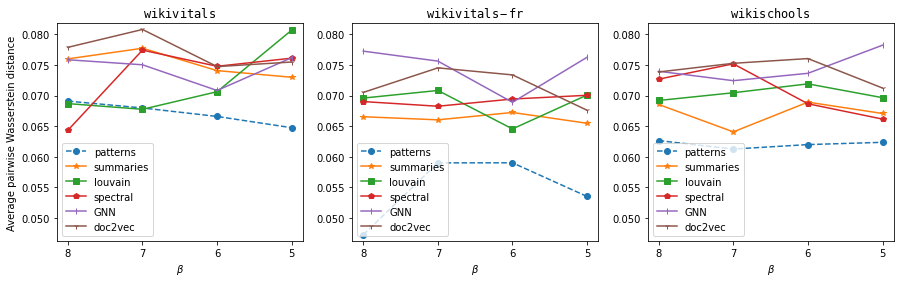

In [705]:
# k = 25, s = 5 
fig, ax = plt.subplots(1, len(datasets), figsize=(15, 4))
markers = ['o', '*', 's', 'p', '|', '1']
min_y = np.inf
max_y = 0

for d, dataset in enumerate(datasets):
    
    vals_concepts = [avgs.get(dataset).get(int(b)).get(5).get('concepts')[0] for b in betas]
    vals_summarized = [avgs.get(dataset).get(int(b)).get(5).get('summarized')[0] for b in betas]
    vals_louvain = [avgs.get(dataset).get(int(b)).get(5).get('louvain')[0] for b in betas]
    vals_spectral = [avgs.get(dataset).get(int(b)).get(5).get('spectral_kmeans')[0] for b in betas]
    vals_gnn = [avgs.get(dataset).get(int(b)).get(5).get('gnn_kmeans')[0] for b in betas]
    vals_doc2vec = [avgs.get(dataset).get(int(b)).get(5).get('doc2vec_kmeans')[0] for b in betas]
    
    min_y = min(min_y, min(np.min(vals_concepts), np.min(vals_summarized), np.min(vals_louvain), np.min(vals_spectral),
               np.min(vals_gnn), np.min(vals_doc2vec)))
    max_y = max(max_y, max(np.max(vals_concepts), np.max(vals_summarized), np.max(vals_louvain), np.max(vals_spectral),
               np.max(vals_gnn), np.max(vals_doc2vec)))
        
    ax[d].plot(vals_concepts, label='patterns', marker=markers[0], linestyle='dashed')
    ax[d].plot(vals_summarized, label='summaries', marker=markers[1])
    ax[d].plot(vals_louvain, label='louvain', marker=markers[2])
    ax[d].plot(vals_spectral, label='spectral', marker=markers[3])
    ax[d].plot(vals_gnn, label='GNN', marker=markers[4])
    ax[d].plot(vals_doc2vec, label='doc2vec', marker=markers[5])
    ax[d].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
    ax[d].set_title(rf'$\tt{dataset}$')
    ax[d].legend(loc='lower left')
    ax[d].set_xlabel(r'$\beta$')
    
for i in range(len(datasets)):
    ax[i].set_ylim(min_y - 0.001, max_y + 0.001)
    
ax[0].set_ylabel('Average pairwise Wasserstein distance');

plt.savefig('../output/img/wd_distances_concepts.eps', dpi=200)

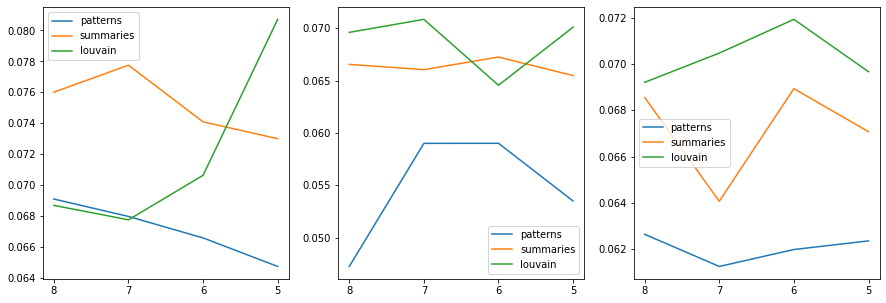

In [699]:
# Embedding dimension = 50
fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5))

for d, dataset in enumerate(datasets):
    
    vals_concepts = [avgs.get(dataset).get(int(b)).get(5).get('concepts')[0] for b in betas]
    vals_summarized = [avgs.get(dataset).get(int(b)).get(5).get('summarized')[0] for b in betas]
    vals_louvain = [avgs.get(dataset).get(int(b)).get(5).get('louvain')[0] for b in betas]
        
    ax[d].plot(vals_concepts, label='patterns')
    ax[d].plot(vals_summarized, label='summaries')
    ax[d].plot(vals_louvain, label='louvain')
    ax[d].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
    ax[d].legend()


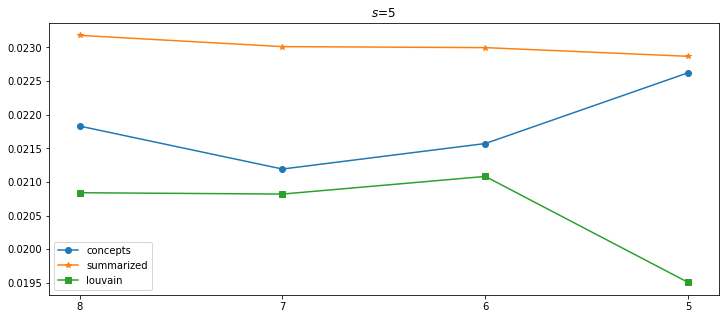

In [584]:
# Embedding dimension = 100
fig, ax = plt.subplots(len(datasets), len(betas), figsize=(12, 5))
markers = ['o', '*', 's', 'p', '|', '1']
ticks_labels = ['8', '7', '6', '5']

for d in datasets:
    
for i, method in enumerate(['concepts', 'summarized', 'louvain']):
    plt.plot(range(len(betas)), avgs.get(method), label=method, marker=markers[i])
    plt.title(rf'$s$=5')
    plt.legend()
    plt.xticks(np.arange(0, len(betas)), labels=ticks_labels)
    plt.yscale
        
#plt.yscale('log')
#plt.xlabel('Embedding size of attributes')
#plt.ylabel('Wasserstein distance (log)')
#plt.legend();

#plt.savefig('img/concept_wd_emb_size_new.svg')

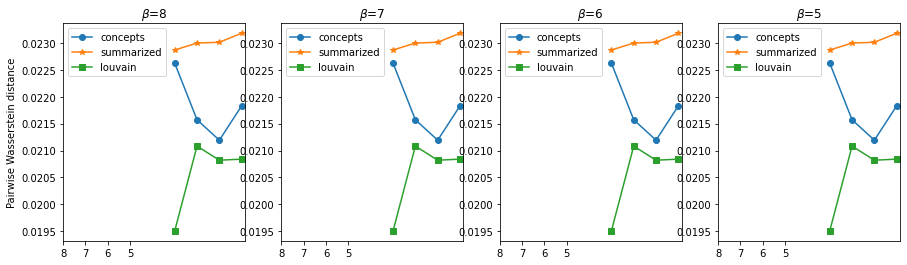

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
markers = ['o', '*', 's', 'p', '|', '1']
ticks_labels = ['8', '7', '6', '5']
for i, method in enumerate(['concepts', 'summarized', 'louvain']):
    for j in range(len(betas)):
        ax[j].plot(betas, avgs.get(method), label=method, marker=markers[i])
        ax[j].set_title(rf'$\beta$={betas[j]}')
        ax[j].legend()
        ax[j].set_xticks(np.arange(0, len(betas)), labels=ticks_labels)
        if j == 0:
            ax[j].set_ylabel('Pairwise Wasserstein distance')
#plt.yscale('log')
#plt.xlabel('Embedding size of attributes')
#plt.ylabel('Wasserstein distance (log)')
#plt.legend();

#plt.savefig('img/concept_wd_emb_size_new.svg')

----

In [504]:
dataset = 'wikivitals'
s = 6
beta = 6
sorted_attributes = True

# Load result
with open(f"../output/result/result_{dataset}_{beta}_{s}_order{str(sorted_attributes)}.bin", "rb") as data:
    result = pickle.load(data)
    
print(len(result))

351


In [505]:
# Load and preprocess data
graph = load_netset(dataset)
adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels
orig_words = words.copy()

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
if order_attributes:
    sort_index = np.argsort(freq_attribute)
else:
    sort_index = np.arange(0, len(freq_attribute))
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

Parsing files...
Done.


In [506]:
# Summarized graph
summarized_adjacency = get_summarized_graph(adjacency, result)
summarized_adjacency

# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
print(len(mask))

236


In [507]:
summarized_adjacency

<10011x10011 sparse matrix of type '<class 'numpy.float64'>'
	with 1262 stored elements in Compressed Sparse Row format>

In [508]:
# Summarized biadjacency
summarized_biadjacency = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
for c in result:
    if len(c[1]) > 0:
        for node in c[0]:
            summarized_biadjacency[node, c[1]] += 1

summarized_biadjacency = sparse.csr_matrix(summarized_biadjacency.astype(bool), shape=summarized_biadjacency.shape)

In [509]:
summarized_biadjacency

<10011x16090 sparse matrix of type '<class 'numpy.bool_'>'
	with 2788 stored elements in Compressed Sparse Row format>

**Connected components in summarized graph**

In [510]:
# Number of connected components considering isolated nodes
labels_cc_summarized = get_connected_components(summarized_adjacency)
print(len(np.unique(labels_cc_summarized)))

9802


In [511]:
# Number of connected components NOT considering isolated nodes
labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
nb_cc = len(np.unique(labels_cc_summarized)) 
print(nb_cc)

31


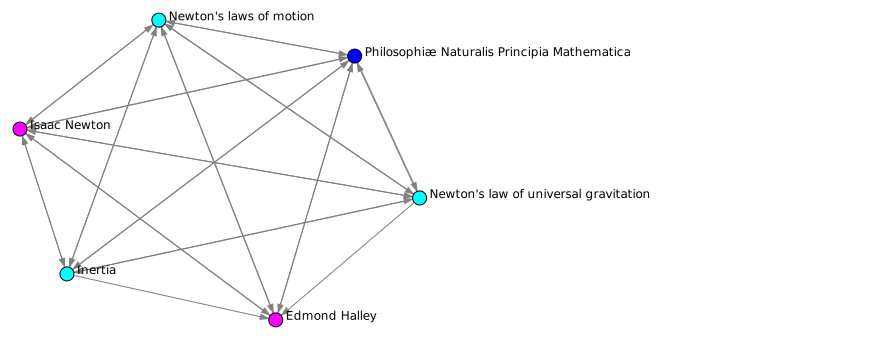

In [541]:
idx = 23
SVG(svg_graph(summarized_adjacency[mask, :][:, mask][labels_cc_summarized == idx, :][:, labels_cc_summarized == idx].astype(bool),
             names=names[mask][labels_cc_summarized==idx], labels=labels[mask][labels_cc_summarized==idx]))

#### Baselines  

**Louvain**

In [549]:
# Manually find resolution so number of communities match number of connected components in 
# summarized adjacency
#resolutions = {'wikivitals': 6.31, 'wikivitals-fr': 0, 'wikischools': 4.42}
resolutions = {'wikivitals': 2.525, 'wikivitals-fr': 0, 'wikischools': 4.42}

louvain = Louvain(resolution=resolutions.get(dataset)) 
labels_louvain = louvain.fit_transform(adjacency)
print(len(Counter(labels_louvain)))

31


**GNN + KMeans**

In [550]:
# Features
features = biadjacency

hidden_dim = 16
n_labels = len(np.unique(labels))

# GNN classifier 
gnn = GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='conv',
                    activations=['Relu', 'Softmax'],
                    verbose=True)

gnn.fit(adjacency, features, labels, train_size=0.8, val_size=0.1, test_size=0.1, n_epochs=50)

In epoch   0, loss: 2.421, train accuracy: 0.113, val accuracy: 0.107
In epoch   5, loss: 2.154, train accuracy: 0.387, val accuracy: 0.388
In epoch  10, loss: 2.069, train accuracy: 0.563, val accuracy: 0.575
In epoch  15, loss: 2.031, train accuracy: 0.660, val accuracy: 0.669
In epoch  20, loss: 1.975, train accuracy: 0.706, val accuracy: 0.705
In epoch  25, loss: 1.902, train accuracy: 0.733, val accuracy: 0.728
In epoch  30, loss: 1.842, train accuracy: 0.763, val accuracy: 0.752
In epoch  35, loss: 1.796, train accuracy: 0.799, val accuracy: 0.795
In epoch  40, loss: 1.760, train accuracy: 0.827, val accuracy: 0.824
In epoch  45, loss: 1.732, train accuracy: 0.850, val accuracy: 0.857


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 11, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [551]:
# KMeans on GNN node embedding
gnn_embedding = gnn.layers[-1].embedding

kmeans = KMeansDense(n_clusters=nb_cc) # k = number of connected components in summarized graph
kmeans_gnn_labels = kmeans.fit_transform(gnn_embedding)

**Spectral + KMeans**

In [552]:
kmeans = KMeans(n_clusters=nb_cc) # k = number of connected components in summarized graph
kmeans_spectral_labels = kmeans.fit_transform(adjacency)

**`Word2Vec` + KMeans**

In [556]:
class MyCorpus():
    """A memory-friendly iterator that yields documents as TaggedDocument objects, i.e tokens associated with index of document."""
    
    def __init__(self, data, vocab, tokens_only=False):
        self.data = data
        self.vocab = vocab
        self.tokens_only = tokens_only
    
    def __iter__(self):
        if isinstance(self.data, sparse.csr_matrix):
            for i, x in enumerate(self.data):
                tokens = list(self.vocab[x.indices])
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
        else:
            if not self.tokens_only:
                for i, x in enumerate(self.data):
                    tokens = list(self.vocab[np.flatnonzero(x)])
                    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            else:
                for i, x in enumerate(self.data):
                    tokens = list(self.vocab[np.flatnonzero(x)])
                    yield tokens

In [557]:
%%time

# Doc2Vec model on whole biadjacency matrix
corpus = list(MyCorpus(biadjacency, orig_words))
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=10, epochs=50)
model.build_vocab(corpus)

# Training model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 51.4 s, sys: 1.59 s, total: 53 s
Wall time: 22.7 s


In [558]:
# KMeans model
kmeans = KMeansDense(n_clusters=nb_cc) # k = number of connected components in summarized graph
kmeans_doc2vec_labels = kmeans.fit_transform(model.dv.vectors)

#### Wasserstein distance between patterns embeddings  

1. Compute patterns/communities for each method  
2. Embedd patterns/communities using spectral embedding  
3. Compute Wasserstein distance between pairs of embeddings and compute the average distance 

In [559]:
%%time

wd_matrix = np.zeros((len(result), len(result)))

# Unexpectedness algorithm + merged patterns (here we call them concepts)
concept_attributes = np.zeros((len(result), biadjacency.shape[1]))

for i, c in enumerate(result[1:]):
    concept_attributes[i, c[1]] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_attributes)

for i, c1 in enumerate(result[1:]):
    for j, c2 in enumerate(result[1:]):    
        wd_matrix[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 8.49 s, sys: 228 ms, total: 8.72 s
Wall time: 5.5 s


In [560]:
%%time

# Unexpectedness algorithm + summarized graph
nb_cc = len(np.unique(labels_cc_summarized))
wd_matrix_summarized = np.zeros((nb_cc, nb_cc))

concept_summarized_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = labels_cc_summarized == c
    indices_attr = summarized_biadjacency[mask][mask_cc].indices
    concept_summarized_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_summarized_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_summarized[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 1.78 s, sys: 110 ms, total: 1.89 s
Wall time: 442 ms


In [561]:
%%time

# Louvain Algorithm
nb_cc = len(np.unique(labels_louvain))
wd_matrix_louvain = np.zeros((nb_cc, nb_cc))

concept_louvain_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = labels_louvain == c
    indices_attr = summarized_biadjacency[mask_cc].indices
    concept_louvain_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_louvain_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_louvain[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 1.74 s, sys: 121 ms, total: 1.86 s
Wall time: 434 ms


In [562]:
%%time

# GNN + KMeans Algorithm
nb_cc = len(np.unique(kmeans_gnn_labels))
wd_matrix_gnn_kmeans = np.zeros((nb_cc, nb_cc))

concept_gnn_kmeans_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = kmeans_gnn_labels == c
    indices_attr = summarized_biadjacency[mask_cc].indices
    concept_gnn_kmeans_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_gnn_kmeans_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_gnn_kmeans[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 1.71 s, sys: 104 ms, total: 1.81 s
Wall time: 426 ms


In [563]:
%%time

# Spectral + KMeans Algorithm
nb_cc = len(np.unique(kmeans_spectral_labels))
wd_matrix_spectral_kmeans = np.zeros((nb_cc, nb_cc))

concept_spectral_kmeans_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = kmeans_spectral_labels == c
    indices_attr = summarized_biadjacency[mask_cc].indices
    concept_spectral_kmeans_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_spectral_kmeans_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_spectral_kmeans[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 1.51 s, sys: 93.9 ms, total: 1.61 s
Wall time: 374 ms


In [564]:
%%time

# Doc2Vec + KMeans Algorithm
nb_cc = len(np.unique(kmeans_doc2vec_labels))
wd_matrix_doc2vec_kmeans = np.zeros((nb_cc, nb_cc))

concept_doc2vec_kmeans_attributes = np.zeros((nb_cc, biadjacency.shape[1]))

for c in range(nb_cc):
    mask_cc = kmeans_doc2vec_labels == c
    indices_attr = summarized_biadjacency[mask_cc].indices
    concept_doc2vec_kmeans_attributes[c, indices_attr] = 1
    
# Embedding of attributes
spectral = Spectral(100)
emb = spectral.fit_transform(concept_doc2vec_kmeans_attributes)

for i in range(nb_cc):
    for j in range(nb_cc):    
        wd_matrix_doc2vec_kmeans[i, j] = wasserstein_distance(emb[i], emb[j])

CPU times: user 1.7 s, sys: 107 ms, total: 1.81 s
Wall time: 416 ms


For different Spectral embedding sizes, compute Wasserstein distances between concept embedding pairs generated using different methods.  
We hypothetize that our algorithm yield concepts with maximum distances between each others.

In [565]:
%%time

ks = [5, 25, 50, 100]#, 125, 150, 175, 200]
avgs = defaultdict(list)

nb_cc = len(np.unique(labels_cc_summarized))
nb_louvain = len(np.unique(labels_louvain))
wd_matrix = np.zeros((len(result), len(result)))
wd_matrix_summarized = np.zeros((nb_cc, nb_cc))
wd_matrix_louvain = np.zeros((nb_louvain, nb_louvain))
wd_matrix_spectral_kmeans = np.zeros((nb_cc, nb_cc))
wd_matrix_gnn_kmeans = np.zeros((nb_cc, nb_cc))
wd_matrix_doc2vec_kmeans = np.zeros((nb_cc, nb_cc))

for k in tqdm(ks): 
    # Unexpectedness algorithm + concepts
    spectral = Spectral(k)
    emb = spectral.fit_transform(concept_attributes)
    for i, c1 in enumerate(result[1:]):
        for j, c2 in enumerate(result[1:]):    
            wd_matrix[i, j] = wasserstein_distance(emb[i], emb[j])
    avgs['concepts'].append(np.mean(wd_matrix))
    
    # Louvain
    spectral = Spectral(k)
    emb = spectral.fit_transform(concept_louvain_attributes)
    for i in range(nb_louvain):
        for j in range(nb_louvain):    
            wd_matrix_louvain[i, j] = wasserstein_distance(emb[i], emb[j])
    avgs['louvain'].append(np.mean(wd_matrix_louvain))
    
    # Others
    spectral_summarized = Spectral(k)
    emb_summarized = spectral_summarized.fit_transform(concept_summarized_attributes)
    spectral_spectral_kmeans = Spectral(k)
    emb_spectral_kmeans = spectral_spectral_kmeans.fit_transform(concept_spectral_kmeans_attributes)
    spectral_gnn_kmeans = Spectral(k)
    emb_gnn_kmeans = spectral_gnn_kmeans.fit_transform(concept_gnn_kmeans_attributes)
    spectral_doc2vec_kmeans = Spectral(k)
    emb_doc2vec_kmeans = spectral_doc2vec_kmeans.fit_transform(concept_doc2vec_kmeans_attributes)
    for i in range(nb_cc):
        for j in range(nb_cc):    
            wd_matrix_summarized[i, j] = wasserstein_distance(emb_summarized[i], emb_summarized[j])
            wd_matrix_spectral_kmeans[i, j] = wasserstein_distance(emb_spectral_kmeans[i], emb_spectral_kmeans[j])
            wd_matrix_gnn_kmeans[i, j] = wasserstein_distance(emb_gnn_kmeans[i], emb_gnn_kmeans[j])
            wd_matrix_doc2vec_kmeans[i, j] = wasserstein_distance(emb_doc2vec_kmeans[i], emb_doc2vec_kmeans[j])
    avgs['summarized'].append(np.mean(wd_matrix_summarized))
    avgs['spectral_kmeans'].append(np.mean(wd_matrix_spectral_kmeans))
    avgs['gnn_kmeans'].append(np.mean(wd_matrix_gnn_kmeans))
    avgs['doc2vec_kmeans'].append(np.mean(wd_matrix_doc2vec_kmeans))

100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.83s/it]

CPU times: user 27.9 s, sys: 1.3 s, total: 29.2 s
Wall time: 15.3 s


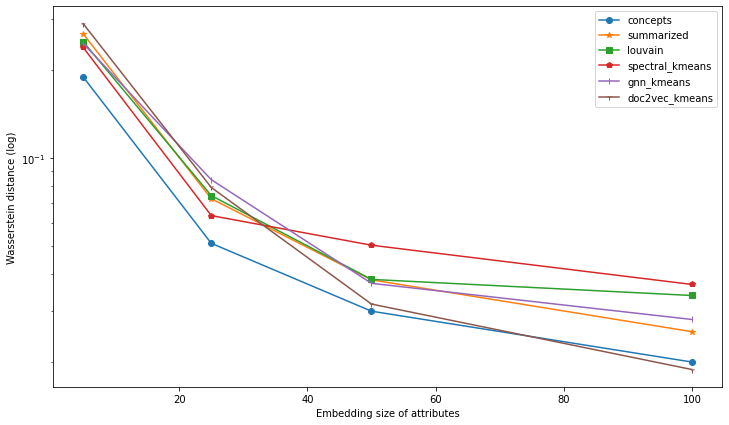

In [570]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
markers = ['o', '*', 's', 'p', '|', '1']
for i, method in enumerate(['concepts', 'summarized', 'louvain', 'spectral_kmeans', 'gnn_kmeans', 'doc2vec_kmeans']):
    plt.plot(ks, avgs.get(method), label=method, marker=markers[i])
plt.yscale('log')
plt.xlabel('Embedding size of attributes')
plt.ylabel('Wasserstein distance (log)')
plt.legend();

#plt.savefig('img/concept_wd_emb_size_new.svg')